# Notebook to explore lat/long position of wells & find nearest neighbors
### and potentially functions to make a dataset of nearest neighbors within certain limits for each well
### and potentially functions to make a dataset of tops and other characteristics for neighboring wells.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import os
import folium
print("folium",folium.__version__)
import branca.colormap as cm
import os
import math
print("welly",welly.__version__)

folium 0.5.0
welly 0.3.5


In [2]:
%%timeit
import os
env = %env

82.9 µs ± 3.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3]:
pd.set_option('display.max_rows', 2000)

In [5]:
picks_dic = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
gis = pd.read_csv('../../../well_lat_lng.csv')
picks_new=picks[picks['HorID']==13000]
picks_paleoz=picks[picks['HorID']==14000]
df_new = pd.merge(wells, picks_new, on='SitID')
df_paleoz = pd.merge(wells, picks_paleoz, on='SitID')
#### NOTE: This now includes the GIS or well_lat_lng dataset too!
df_gis = pd.merge(df_paleoz, gis, on='SitID')
df_new=pd.merge(df_gis, df_new, on='SitID')
df_new.head()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3,54.785907,-110.129320,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3,54.782284,-110.269446,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3,54.785892,-110.186851,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3,54.829624,-110.269422,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


## Possible Steps to Chain for some of the possible features
0. Save and access pickle of all the CSVs chained into single data frame
1. Return array of UWIs of K neighbor wells, place as list in data frame
2. Place nearest well UWI of each well into new column 
3. Place nearest well pick depths into new column
4. place average pick depths of the array of wells into new column
5. do same thing for nearest well and nearest K wells but for average Gr, DPHI, and Resitivity value if present.
6. Calculate nearest and average value for distance between pick in question and known pick.

In [6]:
position = df_new[['lat','lng']]

In [7]:
position

,lat,lng
0,54.785907,-110.129320
1,54.782284,-110.269446
2,54.785892,-110.186851
3,54.829624,-110.269422
4,54.840471,-110.224832
5,54.771449,-110.402983
6,54.785901,-110.422131
7,54.800533,-110.345762
8,54.829633,-110.396621
9,54.840441,-110.320301


In [8]:
tree = neighbors.KDTree(position, leaf_size=2) 

### Saving the tree of all the lat/lng points into pickle file named 'latlng_kd_tree_size2'

In [9]:
#### dumping tree to pickle file
pickle.dump( tree, open( "latlng_kd_tree_leaf2b.p", "wb" ) )
!ls

latlng_kd_tree_leaf2b.p             wellKNN_wKDtree-Post062018_vB.ipynb


### Making sure the kd_tree worked as indended

In [10]:
dist, ind = tree.query([position][0], k=8)  

In [11]:
len(dist)

2193

In [12]:
len(ind)

2193

In [13]:
ind[4:5]

array([[ 4,  3, 64, 63,  2,  1, 65, 66]])

In [14]:
df_new[63:64]

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
63,103699,0684020810000,00/10-08-068-02W4/0,14000,658.5,1,0684020810000,00/10-08-068-02W4/0,13000,572,1,54.873181,-110.269399,0684020810000,00/10-08-068-02W4/0,13000,572,1


In [15]:
df_new[4:5]

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


#### Okay, it appears KD tree has found neigbhors that are in fact near to each other

### Loading pickled tree file:

In [16]:
#### Load the previously dumped (saved) pickle file
#latlng_kd_tree_leaf2 = pickle.load(open( "latlng_kd_tree_size2b.p", "rb" ) )
latlng_kd_tree_leaf2 = pd.read_pickle("latlng_kd_tree_leaf2b.p")
# latlng_kd_tree_leaf2b.p

In [17]:
#### Finding 8 nearest neighbors based on lat/long
dist, ind = latlng_kd_tree_leaf2.query([position][0], k=8)  

In [18]:
#### Testing that ind for index array and dist for array of distances between point and neighbors works after pickling
print(ind,dist)

[[   0    2   62 ...,    1   65    3]
 [   1    3    4 ...,    2   63   68]
 [   2    0    4 ...,    3   62   63]
 ..., 
 [2190 2192 2181 ..., 2191 2186 2180]
 [2191 2189 2192 ..., 2181 2179 2188]
 [2192 2190 2188 ..., 2189 2186 2184]] [[ 0.          0.057531    0.0874943  ...,  0.14017283  0.14539497
   0.14676425]
 [ 0.          0.04734001  0.07332214 ...,  0.08267377  0.09089701
   0.11681159]
 [ 0.          0.057531    0.06649379 ...,  0.09343692  0.10808167
   0.12013968]
 ..., 
 [ 0.          0.036299    0.04921231 ...,  0.08492446  0.095581
   0.09739753]
 [ 0.          0.040093    0.08332469 ...,  0.11798095  0.11947642
   0.13682568]
 [ 0.          0.036299    0.05577925 ...,  0.09853038  0.10224108
   0.12224832]]


## Next step - in 6 parts

A. add an object of neighbors in order of distance as new column

B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

C. Find closest neighbor with base McMurray Pick, make new column with that pick depth

D. Find depth between top and base (B and C), make new column with that depth

E. Depth in D minus base McMurray in each well is nearest neighbor constant thickness prediction of top McMurray prediction

F. Do the same thing as B,C,D,E but for min, average, max of remaining neighbors of K wells

--------------------------

#### A. Add an object of neighbors in order of distance as new column

In [19]:
ind[0]

array([ 0,  2, 62, 64,  4,  1, 65,  3])

In [21]:
#### make a data frame of UWI & index from main dataframe
UWIs = df_new[['UWI']]

In [23]:
UWIs.head()

,UWI
0,00/12-08-067-01W4/0
1,00/07-08-067-02W4/0
2,00/09-11-067-02W4/0
3,00/10-29-067-02W4/0
4,00/06-34-067-02W4/0


In [24]:
#### make a data frame of UWI & index from main dataframe
UWIs = df_new[['UWI']]
#UWIs.join(position, how='outer') 
UWIs_Geog = pd.concat([UWIs, position], axis=1)
UWIs_Geog.head()

,UWI,lat,lng
0,00/12-08-067-01W4/0,54.785907,-110.129320
1,00/07-08-067-02W4/0,54.782284,-110.269446
2,00/09-11-067-02W4/0,54.785892,-110.186851
3,00/10-29-067-02W4/0,54.829624,-110.269422
4,00/06-34-067-02W4/0,54.840471,-110.224832


In [25]:
UWIs.head()

,UWI
0,00/12-08-067-01W4/0
1,00/07-08-067-02W4/0
2,00/09-11-067-02W4/0
3,00/10-29-067-02W4/0
4,00/06-34-067-02W4/0


In [26]:
#### Add object of tree for 8 neighbors to a dataframe

neighbor_array_per_well_row = []
#### for i in ind.length
for i in range(len(ind)):
    #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
    neighbors_ind = ind[i][1:]
    # for each index in that array, 
    counter = 1
    array_of_holder_obj = []
    for n in neighbors_ind:
        #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
        holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
        #### get the distance into the temp object using index of i and each,
        holder_obj['distance'] = dist[i][counter]
        #### get the UWI using i and the dataframe
        holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
        #### and position via "counter"
        holder_obj['neighbor'] = counter
        #### add the temp object populated as a column entry into an array
        counter = counter + 1
        array_of_holder_obj.append(holder_obj)
    #### turn array of objects into series and add as new column to dataframe
    neighbor_array_per_well_row.append(array_of_holder_obj)
UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)


In [27]:
#### Test results Part 1
UWIs_Geog.head()

,UWI,lat,lng,Neighbors_Obj
0,00/12-08-067-01W4/0,54.785907,-110.129320,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',..."
1,00/07-08-067-02W4/0,54.782284,-110.269446,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',..."
2,00/09-11-067-02W4/0,54.785892,-110.186851,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',..."
3,00/10-29-067-02W4/0,54.829624,-110.269422,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',..."
4,00/06-34-067-02W4/0,54.840471,-110.224832,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',..."


In [28]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000



#### Had to change display options to get this to print in full!
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(UWIs_Geog[0:1]['Neighbors_Obj'])

0    [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]
Name: Neighbors_Obj, dtype: object


placeholder.... title

In [29]:
df_new.head()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3,54.785907,-110.129320,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3,54.782284,-110.269446,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3,54.785892,-110.186851,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3,54.829624,-110.269422,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


In [30]:
#### Creating a new dataframe for use below
df_new_cleaned = df_new[['SitID','HorID_x','Pick_x','Quality_x','HorID','Pick','Quality','lat','lng','UWI']].copy()

df_new_cleaned
df_new_cleaned['McMurray_Base_HorID'] = df_new_cleaned[['HorID_x']]
df_new_cleaned['McMurray_Base_HorID'] = df_new_cleaned['HorID_x']
df_new_cleaned['McMurray_Top_HorID'] = df_new_cleaned['HorID']
df_new_cleaned['McMurray_Base_DEPTH'] = df_new_cleaned['Pick_x']
df_new_cleaned['McMurray_Top_DEPTH'] = df_new_cleaned['Pick']
df_new_cleaned['McMurray_Base_Qual'] = df_new_cleaned['Quality_x']
df_new_cleaned['McMurray_Top_Qual'] = df_new_cleaned['Quality']
df_new_cleaned = df_new_cleaned[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI']]

df_new_cleaned.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0


#### Merge df_new_cleaned data frame with UWIs_Geog data frame

In [31]:
df_new_cleaned_plus_nn = pd.concat([df_new_cleaned, UWIs_Geog[['Neighbors_Obj']].copy()], axis=1)
df_new_cleaned_plus_nn.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]"
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]"
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]"
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]"
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0501344694696}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0552825613462}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.0771552400618}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0918035212614}]"


#### This is how to access the data on nearest neigbhors in the 'Neighbors_Obj' column

In [32]:
#### The object for the 1st neighbor of the 1 index well
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][1]

{'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.073322138300783546}

In [33]:
#### The distance from the well in question for that row to the 1st neighbor 
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][3]['UWI']

'00/10-14-067-03W4/0'

In [34]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [35]:
### col 3 is McMurray_Base_DEPTH
df_new_cleaned_plus_nn.iloc[0,3]

'561'

In [36]:
### col 4 is McMurray_Top_DEPTH
df_new_cleaned_plus_nn.iloc[0,4]

'475'

In [37]:
test = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/06-34-067-02W4/0')
print(type(test),test)

<class 'int'> 4


In [38]:
df_new_cleaned_plus_nn.loc[1:2,'Neighbors_Obj'][2]

[{'neighbor': 1,
  'UWI': '00/12-08-067-01W4/0',
  'distance': 0.057531001955478993},
 {'neighbor': 2,
  'UWI': '00/06-34-067-02W4/0',
  'distance': 0.06649378619088428},
 {'neighbor': 3,
  'UWI': '00/07-08-067-02W4/0',
  'distance': 0.08267376663125782},
 {'neighbor': 4,
  'UWI': '00/09-11-068-02W4/0',
  'distance': 0.087284001655512117},
 {'neighbor': 5,
  'UWI': '00/10-29-067-02W4/0',
  'distance': 0.093436919175440364},
 {'neighbor': 6,
  'UWI': '00/11-08-068-01W4/0',
  'distance': 0.10808166919974113},
 {'neighbor': 7,
  'UWI': '00/10-08-068-02W4/0',
  'distance': 0.12013967631468725}]

### B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

In [39]:
index_of_neigh = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/09-11-067-02W4/0')
index_of_neigh

2

In [40]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [41]:
df_new_cleaned_plus_nn['SitID'][1]

102497

In [42]:
#### Neighbors_Obj must be 10th Col!!

def broadcastFuncForFindNearestNPickDepth(df,pickColInt,newPickColName):
    #### For each row in dataframe,
    df[newPickColName] = np.nan
    print( df.iloc[0:1][newPickColName])
    for eachRow in range(len(df)):
        #### Find the nearest neighbor UWI
        print(eachRow)
        UWI = df.iloc[eachRow,10][1]['UWI']
        print(type(UWI),"type to right of ",UWI)
        #### With the UWI from above, find the pickDepthName
        index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
        print("index_of_neigh_UWI= ",index_of_neigh_UWI)
        pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
        print("pick_depth ",pick_depth)
        try:
            pick_depth = float(pick_depth)
        except:
            UWI = df.iloc[eachRow,10][2]['UWI']
            index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
            pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
            try:
                pick_depth = float(pick_depth)
            except:
                UWI = df.iloc[eachRow,10][3]['UWI']
                index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                try:
                    pick_depth = float(pick_depth)
                except:
                    UWI = df.iloc[eachRow,10][4]['UWI']
                    index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                    pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                    try:
                        pick_depth = float(pick_depth)
                    except:
                        pick_depth = "no_pick"
            
        #### Write the pickDepthName to a new column
#         df[newPickColName][eachRow] = pick_depth
        eachRowP1 = eachRow+1
        df.iloc[eachRow:eachRowP1][newPickColName] = pick_depth
    return df

In [43]:
temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,4,'NN1_McMurray_Top_DEPTH')

0   NaN
Name: NN1_McMurray_Top_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  62
pick_depth  544
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529


/Users/justingosses/anaconda/envs/MannvilleDask/lib/python3.6/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  64
pick_depth  514
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  553.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  509
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  511
13
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  511
14
<class 'str'> type to right of  00/10-33-067-05

96
<class 'str'> type to right of  00/10-33-067-11W4/0
index_of_neigh_UWI=  33
pick_depth  509
97
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  455
98
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  455
99
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  455
100
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  102
pick_depth  470
101
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  102
pick_depth  470
102
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  155
pick_depth  460
103
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  155
pick_depth  460
104
<class 'str'> type to right of  00/11-12-068-13W4/0
index_of_neigh_UWI=  105
pick_depth  457.2
105
<class 'str'> type to right of  00/11-36-067-13W4/0
index_of_neigh_UWI=  41
pick_depth  466.34
106
<class 'str'> type to right of

185
<class 'str'> type to right of  00/09-35-070-06W4/0
index_of_neigh_UWI=  190
pick_depth  473.5
186
<class 'str'> type to right of  00/05-19-070-05W4/0
index_of_neigh_UWI=  185
pick_depth  468
187
<class 'str'> type to right of  00/06-36-069-06W4/0
index_of_neigh_UWI=  137
pick_depth  504
188
<class 'str'> type to right of  00/10-33-070-06W4/0
index_of_neigh_UWI=  189
pick_depth  440
189
<class 'str'> type to right of  00/10-17-071-06W4/0
index_of_neigh_UWI=  289
pick_depth  452.5
190
<class 'str'> type to right of  00/09-14-071-06W4/0
index_of_neigh_UWI=  288
pick_depth  468
191
<class 'str'> type to right of  00/12-30-069-07W4/0
index_of_neigh_UWI=  139
pick_depth  470
192
<class 'str'> type to right of  00/06-30-069-09W4/0
index_of_neigh_UWI=  146
pick_depth  585
193
<class 'str'> type to right of  00/11-05-070-09W4/0
index_of_neigh_UWI=  192
pick_depth  492.5
194
<class 'str'> type to right of  00/06-16-070-09W4/0
index_of_neigh_UWI=  193
pick_depth  428
195
<class 'str'> type t

270
<class 'str'> type to right of  00/11-33-070-03W5/0
index_of_neigh_UWI=  269
pick_depth          
271
<class 'str'> type to right of  00/10-17-070-03W5/0
index_of_neigh_UWI=  268
pick_depth  722
272
<class 'str'> type to right of  00/11-23-070-05W5/0
index_of_neigh_UWI=  277
pick_depth  878.5
273
<class 'str'> type to right of  00/10-17-070-03W5/0
index_of_neigh_UWI=  268
pick_depth  722
274
<class 'str'> type to right of  00/11-10-070-05W5/0
index_of_neigh_UWI=  275
pick_depth  893
275
<class 'str'> type to right of  00/11-05-070-05W5/0
index_of_neigh_UWI=  274
pick_depth  920.5
276
<class 'str'> type to right of  00/11-10-070-05W5/0
index_of_neigh_UWI=  275
pick_depth  893
277
<class 'str'> type to right of  00/16-12-071-05W5/0
index_of_neigh_UWI=  386
pick_depth  805.89
278
<class 'str'> type to right of  00/06-08-074-01W4/0
index_of_neigh_UWI=  602
pick_depth  517
279
<class 'str'> type to right of  00/12-36-072-03W4/0
index_of_neigh_UWI=  391
pick_depth  497
280
<class 'str'> 

357
<class 'str'> type to right of  00/16-20-072-23W4/0
index_of_neigh_UWI=  465
pick_depth  624
358
<class 'str'> type to right of  00/11-21-071-24W4/0
index_of_neigh_UWI=  359
pick_depth  623.32
359
<class 'str'> type to right of  00/10-31-071-24W4/0
index_of_neigh_UWI=  360
pick_depth  624.84
360
<class 'str'> type to right of  00/10-18-071-24W4/0
index_of_neigh_UWI=  358
pick_depth  628.19
361
<class 'str'> type to right of  00/11-21-071-24W4/0
index_of_neigh_UWI=  359
pick_depth  623.32
362
<class 'str'> type to right of  00/10-23-070-26W4/0
index_of_neigh_UWI=  255
pick_depth  655.32
363
<class 'str'> type to right of  00/06-21-071-25W4/0
index_of_neigh_UWI=  364
pick_depth  601.07
364
<class 'str'> type to right of  00/06-32-070-25W4/0
index_of_neigh_UWI=  252
pick_depth          
365
<class 'str'> type to right of  00/10-31-071-24W4/0
index_of_neigh_UWI=  360
pick_depth  624.84
366
<class 'str'> type to right of  00/10-15-071-26W4/0
index_of_neigh_UWI=  367
pick_depth  639.78
3

443
<class 'str'> type to right of  00/07-13-072-17W4/0
index_of_neigh_UWI=  445
pick_depth          
444
<class 'str'> type to right of  00/07-25-071-18W4/0
index_of_neigh_UWI=  336
pick_depth          
445
<class 'str'> type to right of  00/10-23-072-17W4/0
index_of_neigh_UWI=  446
pick_depth  415.75
446
<class 'str'> type to right of  00/06-36-072-17W4/0
index_of_neigh_UWI=  447
pick_depth  448.06
447
<class 'str'> type to right of  00/10-23-072-17W4/0
index_of_neigh_UWI=  446
pick_depth  415.75
448
<class 'str'> type to right of  00/06-34-072-18W4/0
index_of_neigh_UWI=  451
pick_depth  449.28
449
<class 'str'> type to right of  00/07-25-071-18W4/0
index_of_neigh_UWI=  336
pick_depth          
450
<class 'str'> type to right of  00/06-34-072-18W4/0
index_of_neigh_UWI=  451
pick_depth  449.28
451
<class 'str'> type to right of  00/10-05-073-18W4/0
index_of_neigh_UWI=  551
pick_depth  464.52
452
<class 'str'> type to right of  00/12-30-071-19W4/0
index_of_neigh_UWI=  340
pick_depth  4

index_of_neigh_UWI=  427
pick_depth  449
529
<class 'str'> type to right of  00/06-07-073-11W4/0
index_of_neigh_UWI=  524
pick_depth  476.5
530
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  635
pick_depth  480
531
<class 'str'> type to right of  00/13-22-073-13W4/0
index_of_neigh_UWI=  532
pick_depth  497.5
532
<class 'str'> type to right of  00/07-36-073-13W4/0
index_of_neigh_UWI=  534
pick_depth  480.5
533
<class 'str'> type to right of  00/10-01-074-14W4/0
index_of_neigh_UWI=  643
pick_depth  520
534
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  635
pick_depth  480
535
<class 'str'> type to right of  02/10-30-072-14W4/0
index_of_neigh_UWI=  435
pick_depth  454
536
<class 'str'> type to right of  00/06-06-073-14W4/0
index_of_neigh_UWI=  535
pick_depth  455.68
537
<class 'str'> type to right of  00/07-13-073-15W4/0
index_of_neigh_UWI=  540
pick_depth  486
538
<class 'str'> type to right of  00/11-30-073-13W4/0
index_of_neigh_UWI=  

619
<class 'str'> type to right of  00/06-20-074-06W4/0
index_of_neigh_UWI=  615
pick_depth  410
620
<class 'str'> type to right of  00/11-10-074-08W4/0
index_of_neigh_UWI=  621
pick_depth  483
621
<class 'str'> type to right of  00/06-34-073-08W4/0
index_of_neigh_UWI=  515
pick_depth  495
622
<class 'str'> type to right of  00/06-34-073-08W4/0
index_of_neigh_UWI=  515
pick_depth  495
623
<class 'str'> type to right of  00/10-11-074-09W4/0
index_of_neigh_UWI=  625
pick_depth  442
624
<class 'str'> type to right of  00/07-27-074-09W4/0
index_of_neigh_UWI=  627
pick_depth  445.62
625
<class 'str'> type to right of  00/11-18-074-08W4/0
index_of_neigh_UWI=  623
pick_depth  452.5
626
<class 'str'> type to right of  00/07-27-074-09W4/0
index_of_neigh_UWI=  627
pick_depth  445.62
627
<class 'str'> type to right of  00/10-11-074-09W4/0
index_of_neigh_UWI=  625
pick_depth  442
628
<class 'str'> type to right of  00/03-30-074-10W4/0
index_of_neigh_UWI=  629
pick_depth  473.66
629
<class 'str'> t

719
<class 'str'> type to right of  00/10-34-075-07W4/0
index_of_neigh_UWI=  720
pick_depth  396.24
720
<class 'str'> type to right of  AA/06-14-076-07W4/0
index_of_neigh_UWI=  808
pick_depth  373.5
721
<class 'str'> type to right of  00/12-14-075-08W4/0
index_of_neigh_UWI=  722
pick_depth  444.65
722
<class 'str'> type to right of  00/10-29-075-08W4/0
index_of_neigh_UWI=  723
pick_depth  460.86
723
<class 'str'> type to right of  00/11-08-075-08W4/0
index_of_neigh_UWI=  721
pick_depth  441
724
<class 'str'> type to right of  00/12-14-075-08W4/0
index_of_neigh_UWI=  722
pick_depth  444.65
725
<class 'str'> type to right of  00/07-27-074-09W4/0
index_of_neigh_UWI=  627
pick_depth  445.62
726
<class 'str'> type to right of  00/07-27-074-09W4/0
index_of_neigh_UWI=  627
pick_depth  445.62
727
<class 'str'> type to right of  00/06-04-075-09W4/0
index_of_neigh_UWI=  725
pick_depth  441
728
<class 'str'> type to right of  00/07-21-076-09W4/0
index_of_neigh_UWI=  816
pick_depth  449.5
729
<cla

812
<class 'str'> type to right of  00/07-35-075-08W4/0
index_of_neigh_UWI=  724
pick_depth  409
813
<class 'str'> type to right of  00/11-02-077-08W4/0
index_of_neigh_UWI=  912
pick_depth  325
814
<class 'str'> type to right of  00/11-02-077-08W4/0
index_of_neigh_UWI=  912
pick_depth  325
815
<class 'str'> type to right of  00/08-36-076-10W4/0
index_of_neigh_UWI=  821
pick_depth  402.5
816
<class 'str'> type to right of  00/10-26-076-09W4/0
index_of_neigh_UWI=  817
pick_depth  411.78
817
<class 'str'> type to right of  00/07-21-076-09W4/0
index_of_neigh_UWI=  816
pick_depth  449.5
818
<class 'str'> type to right of  00/12-13-076-10W4/0
index_of_neigh_UWI=  819
pick_depth  433
819
<class 'str'> type to right of  00/07-20-076-09W4/0
index_of_neigh_UWI=  815
pick_depth  452
820
<class 'str'> type to right of  00/07-36-076-11W4/0
index_of_neigh_UWI=  824
pick_depth  448.97
821
<class 'str'> type to right of  00/12-13-076-10W4/0
index_of_neigh_UWI=  819
pick_depth  433
822
<class 'str'> ty

pick_depth  324
909
<class 'str'> type to right of  AA/10-11-077-08W4/0
index_of_neigh_UWI=  913
pick_depth  317
910
<class 'str'> type to right of  00/10-04-077-07W4/0
index_of_neigh_UWI=  908
pick_depth  312
911
<class 'str'> type to right of  00/10-04-077-07W4/0
index_of_neigh_UWI=  908
pick_depth  312
912
<class 'str'> type to right of  00/03-12-077-08W4/0
index_of_neigh_UWI=  914
pick_depth  323.5
913
<class 'str'> type to right of  00/03-12-077-08W4/0
index_of_neigh_UWI=  914
pick_depth  323.5
914
<class 'str'> type to right of  00/11-06-077-07W4/0
index_of_neigh_UWI=  909
pick_depth  324
915
<class 'str'> type to right of  AA/10-11-078-08W4/0
index_of_neigh_UWI=  1011
pick_depth  307
916
<class 'str'> type to right of  00/10-14-077-10W4/0
index_of_neigh_UWI=  920
pick_depth  392.5
917
<class 'str'> type to right of  00/10-26-076-09W4/0
index_of_neigh_UWI=  817
pick_depth  411.78
918
<class 'str'> type to right of  00/06-11-077-09W4/0
index_of_neigh_UWI=  917
pick_depth  391.97
9

index_of_neigh_UWI=  1090
pick_depth  288.34
997
<class 'str'> type to right of  00/10-05-079-04W4/0
index_of_neigh_UWI=  1090
pick_depth  288.34
998
<class 'str'> type to right of  00/08-20-077-05W4/0
index_of_neigh_UWI=  902
pick_depth  327
999
<class 'str'> type to right of  00/05-04-078-05W4/0
index_of_neigh_UWI=  998
pick_depth  339
1000
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  274
1001
<class 'str'> type to right of  00/05-21-078-05W4/0
index_of_neigh_UWI=  999
pick_depth  323
1002
<class 'str'> type to right of  00/06-16-077-06W4/0
index_of_neigh_UWI=  906
pick_depth  315.16
1003
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  1000
pick_depth  304
1004
<class 'str'> type to right of  00/08-04-079-06W4/0
index_of_neigh_UWI=  1098
pick_depth  251
1005
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  1000
pick_depth  304
1006
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of

1093
<class 'str'> type to right of  00/10-10-080-04W4/0
index_of_neigh_UWI=  1179
pick_depth  243.84
1094
<class 'str'> type to right of  00/08-09-079-05W4/0
index_of_neigh_UWI=  1095
pick_depth  252
1095
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  274
1096
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  274
1097
<class 'str'> type to right of  00/07-01-080-06W4/0
index_of_neigh_UWI=  1186
pick_depth  205
1098
<class 'str'> type to right of  00/11-28-079-06W4/0
index_of_neigh_UWI=  1100
pick_depth  251
1099
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  274
1100
<class 'str'> type to right of  00/07-06-080-06W4/0
index_of_neigh_UWI=  1187
pick_depth  291
1101
<class 'str'> type to right of  00/07-06-080-06W4/0
index_of_neigh_UWI=  1187
pick_depth  291
1102
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  1103
pick_depth  285
1103
<c

index_of_neigh_UWI=  1093
pick_depth  215.8
1179
<class 'str'> type to right of  00/11-23-080-04W4/0
index_of_neigh_UWI=  1180
pick_depth  259.99
1180
<class 'str'> type to right of  00/10-09-080-04W4/0
index_of_neigh_UWI=  1178
pick_depth  225.55
1181
<class 'str'> type to right of  00/10-09-080-04W4/0
index_of_neigh_UWI=  1178
pick_depth  225.55
1182
<class 'str'> type to right of  00/10-31-079-05W4/0
index_of_neigh_UWI=  1097
pick_depth  203
1183
<class 'str'> type to right of  00/10-04-081-05W4/0
index_of_neigh_UWI=  1273
pick_depth  191.41
1184
<class 'str'> type to right of  00/10-04-081-05W4/0
index_of_neigh_UWI=  1273
pick_depth  191.41
1185
<class 'str'> type to right of  00/16-15-080-05W4/0
index_of_neigh_UWI=  1183
pick_depth  221.5
1186
<class 'str'> type to right of  00/10-31-079-05W4/0
index_of_neigh_UWI=  1097
pick_depth  203
1187
<class 'str'> type to right of  00/10-25-079-07W4/0
index_of_neigh_UWI=  1104
pick_depth  297
1188
<class 'str'> type to right of  00/07-01-08

1268
<class 'str'> type to right of  00/11-11-081-03W4/0
index_of_neigh_UWI=  1267
pick_depth  224.64
1269
<class 'str'> type to right of  00/12-17-081-04W4/0
index_of_neigh_UWI=  1270
pick_depth  187
1270
<class 'str'> type to right of  00/11-04-081-04W4/0
index_of_neigh_UWI=  1269
pick_depth  193
1271
<class 'str'> type to right of  00/11-04-081-04W4/0
index_of_neigh_UWI=  1269
pick_depth  193
1272
<class 'str'> type to right of  00/05-22-082-04W4/0
index_of_neigh_UWI=  1357
pick_depth  197
1273
<class 'str'> type to right of  00/16-15-080-05W4/0
index_of_neigh_UWI=  1183
pick_depth  221.5
1274
<class 'str'> type to right of  00/14-36-080-05W4/0
index_of_neigh_UWI=  1185
pick_depth  186.54
1275
<class 'str'> type to right of  00/08-01-081-06W4/0
index_of_neigh_UWI=  1277
pick_depth  212
1276
<class 'str'> type to right of  00/10-13-081-05W4/0
index_of_neigh_UWI=  1274
pick_depth  207.26
1277
<class 'str'> type to right of  AA/11-19-081-05W4/0
index_of_neigh_UWI=  1275
pick_depth  217

1353
<class 'str'> type to right of  00/09-13-083-02W4/0
index_of_neigh_UWI=  1430
pick_depth  232
1354
<class 'str'> type to right of  00/06-09-083-03W4/0
index_of_neigh_UWI=  1433
pick_depth  207.87
1355
<class 'str'> type to right of  00/10-09-082-03W4/0
index_of_neigh_UWI=  1354
pick_depth  197.51
1356
<class 'str'> type to right of  00/05-22-082-04W4/0
index_of_neigh_UWI=  1357
pick_depth  197
1357
<class 'str'> type to right of  00/11-35-081-04W4/0
index_of_neigh_UWI=  1272
pick_depth  192.5
1358
<class 'str'> type to right of  00/07-24-082-05W4/0
index_of_neigh_UWI=  1360
pick_depth  200
1359
<class 'str'> type to right of  00/10-08-083-05W4/0
index_of_neigh_UWI=  1439
pick_depth  251.5
1360
<class 'str'> type to right of  00/07-06-083-04W4/0
index_of_neigh_UWI=  1435
pick_depth  209.5
1361
<class 'str'> type to right of  00/06-35-082-06W4/0
index_of_neigh_UWI=  1365
pick_depth  217.32
1362
<class 'str'> type to right of  AA/14-36-082-07W4/0
index_of_neigh_UWI=  1369
pick_depth 

1452
<class 'str'> type to right of  AA/10-23-082-08W4/0
index_of_neigh_UWI=  1371
pick_depth  454
1453
<class 'str'> type to right of  AA/06-08-083-08W4/0
index_of_neigh_UWI=  1451
pick_depth  440.5
1454
<class 'str'> type to right of  00/06-27-083-09W4/0
index_of_neigh_UWI=  1456
pick_depth  457.81
1455
<class 'str'> type to right of  00/11-31-083-09W4/0
index_of_neigh_UWI=  1457
pick_depth  422.45
1456
<class 'str'> type to right of  00/11-17-083-09W4/0
index_of_neigh_UWI=  1455
pick_depth  442.26
1457
<class 'str'> type to right of  AA/10-26-083-10W4/0
index_of_neigh_UWI=  1460
pick_depth  434.95
1458
<class 'str'> type to right of  AA/11-29-082-10W4/0
index_of_neigh_UWI=  1380
pick_depth  433.73
1459
<class 'str'> type to right of  00/11-17-083-09W4/0
index_of_neigh_UWI=  1455
pick_depth  442.26
1460
<class 'str'> type to right of  00/11-31-083-09W4/0
index_of_neigh_UWI=  1457
pick_depth  422.45
1461
<class 'str'> type to right of  AA/10-26-083-11W4/0
index_of_neigh_UWI=  1464
pic

index_of_neigh_UWI=  1540
pick_depth          
1537
<class 'str'> type to right of  00/04-26-084-15W4/0
index_of_neigh_UWI=  1540
pick_depth          
1538
<class 'str'> type to right of  00/04-26-084-15W4/0
index_of_neigh_UWI=  1540
pick_depth          
1539
<class 'str'> type to right of  00/01-05-085-15W4/0
index_of_neigh_UWI=  1587
pick_depth  253
1540
<class 'str'> type to right of  00/04-30-084-14W4/0
index_of_neigh_UWI=  1536
pick_depth  256
1541
<class 'str'> type to right of  00/06-24-083-16W4/0
index_of_neigh_UWI=  1477
pick_depth  259.08
1542
<class 'str'> type to right of  00/07-34-083-16W4/0
index_of_neigh_UWI=  1478
pick_depth  261
1543
<class 'str'> type to right of  00/04-20-084-15W4/0
index_of_neigh_UWI=  1539
pick_depth  253
1544
<class 'str'> type to right of  00/06-24-084-16W4/0
index_of_neigh_UWI=  1543
pick_depth  257
1545
<class 'str'> type to right of  00/01-21-084-17W4/0
index_of_neigh_UWI=  1547
pick_depth  263
1546
<class 'str'> type to right of  00/07-25-083

1630
<class 'str'> type to right of  00/10-36-085-19W4/0
index_of_neigh_UWI=  1596
pick_depth          
1631
<class 'str'> type to right of  00/14-20-087-21W4/0
index_of_neigh_UWI=  1667
pick_depth  303
1632
<class 'str'> type to right of  00/11-19-085-22W4/0
index_of_neigh_UWI=  1600
pick_depth  337.11
1633
<class 'str'> type to right of  00/11-32-086-22W4/0
index_of_neigh_UWI=  1634
pick_depth  346.25
1634
<class 'str'> type to right of  00/10-08-086-22W4/0
index_of_neigh_UWI=  1633
pick_depth  355.7
1635
<class 'str'> type to right of  00/07-29-086-21W4/0
index_of_neigh_UWI=  1631
pick_depth  351.74
1636
<class 'str'> type to right of  00/06-34-086-23W4/0
index_of_neigh_UWI=  1637
pick_depth  321.87
1637
<class 'str'> type to right of  00/11-24-087-23W4/0
index_of_neigh_UWI=  1671
pick_depth  328.27
1638
<class 'str'> type to right of  00/07-04-087-25W4/0
index_of_neigh_UWI=  1672
pick_depth  439.52
1639
<class 'str'> type to right of  AA/09-28-087-07W4/0
index_of_neigh_UWI=  1642
p

1721
<class 'str'> type to right of  AA/13-28-089-07W4/0
index_of_neigh_UWI=  1722
pick_depth  147.5
1722
<class 'str'> type to right of  AA/04-03-090-07W4/0
index_of_neigh_UWI=  1761
pick_depth  144.5
1723
<class 'str'> type to right of  AA/13-28-089-07W4/0
index_of_neigh_UWI=  1722
pick_depth  147.5
1724
<class 'str'> type to right of  AA/05-32-089-08W4/0
index_of_neigh_UWI=  1726
pick_depth  93.5
1725
<class 'str'> type to right of  AA/12-34-089-08W4/0
index_of_neigh_UWI=  1727
pick_depth  117.5
1726
<class 'str'> type to right of  AB/10-08-089-08W4/0
index_of_neigh_UWI=  1724
pick_depth  76.2
1727
<class 'str'> type to right of  AA/01-02-090-08W4/0
index_of_neigh_UWI=  1766
pick_depth  132
1728
<class 'str'> type to right of  AA/10-35-089-09W4/0
index_of_neigh_UWI=  1731
pick_depth  64.62
1729
<class 'str'> type to right of  AA/10-35-089-09W4/0
index_of_neigh_UWI=  1731
pick_depth  64.62
1730
<class 'str'> type to right of  AA/10-35-089-09W4/0
index_of_neigh_UWI=  1731
pick_depth  

1824
<class 'str'> type to right of  AA/10-29-091-15W4/0
index_of_neigh_UWI=  1825
pick_depth  188.37
1825
<class 'str'> type to right of  AA/10-26-091-15W4/0
index_of_neigh_UWI=  1824
pick_depth  187
1826
<class 'str'> type to right of  AA/10-26-090-16W4/0
index_of_neigh_UWI=  1789
pick_depth  184
1827
<class 'str'> type to right of  AA/10-11-091-16W4/0
index_of_neigh_UWI=  1826
pick_depth  202
1828
<class 'str'> type to right of  AA/10-29-092-16W4/0
index_of_neigh_UWI=  1873
pick_depth  208.18
1829
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  220
1830
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  220
1831
<class 'str'> type to right of  AA/07-02-091-17W4/0
index_of_neigh_UWI=  1829
pick_depth  225
1832
<class 'str'> type to right of  00/10-26-091-18W4/0
index_of_neigh_UWI=  1835
pick_depth  236
1833
<class 'str'> type to right of  00/07-14-091-18W4/0
index_of_neigh_UWI=  1834
pick_depth  235
1834

index_of_neigh_UWI=  1958
pick_depth  9
1910
<class 'str'> type to right of  AA/05-05-094-09W4/0
index_of_neigh_UWI=  1953
pick_depth  8
1911
<class 'str'> type to right of  AA/01-30-092-11W4/0
index_of_neigh_UWI=  1862
pick_depth  65.23
1912
<class 'str'> type to right of  AC/03-04-093-11W4/0
index_of_neigh_UWI=  1911
pick_depth  52
1913
<class 'str'> type to right of  AA/01-32-093-11W4/0
index_of_neigh_UWI=  1914
pick_depth  55
1914
<class 'str'> type to right of  AB/12-15-093-11W4/0
index_of_neigh_UWI=  1912
pick_depth  62
1915
<class 'str'> type to right of  AA/16-12-093-13W4/0
index_of_neigh_UWI=  1919
pick_depth  136.5
1916
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1915
pick_depth  134.5
1917
<class 'str'> type to right of  AA/05-01-094-12W4/0
index_of_neigh_UWI=  1965
pick_depth  74
1918
<class 'str'> type to right of  AA/05-01-094-12W4/0
index_of_neigh_UWI=  1965
pick_depth  74
1919
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neig

1998
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1944
pick_depth  272
1999
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1944
pick_depth  272
2000
<class 'str'> type to right of  AA/11-32-094-06W4/0
index_of_neigh_UWI=  1943
pick_depth  252
2001
<class 'str'> type to right of  AA/01-01-095-07W4/0
index_of_neigh_UWI=  2000
pick_depth  221
2002
<class 'str'> type to right of  AA/10-30-094-07W4/0
index_of_neigh_UWI=  1948
pick_depth  152
2003
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  2048
pick_depth  98
2004
<class 'str'> type to right of  AA/10-30-094-07W4/0
index_of_neigh_UWI=  1948
pick_depth  152
2005
<class 'str'> type to right of  AA/14-27-094-08W4/0
index_of_neigh_UWI=  1951
pick_depth  61
2006
<class 'str'> type to right of  AA/11-05-096-08W4/0
index_of_neigh_UWI=  2052
pick_depth  17.68
2007
<class 'str'> type to right of  AA/10-15-095-08W4/0
index_of_neigh_UWI=  2005
pick_depth  25
2008
<class

index_of_neigh_UWI=  2082
pick_depth  318
2082
<class 'str'> type to right of  AA/03-02-096-15W4/0
index_of_neigh_UWI=  2081
pick_depth  303
2083
<class 'str'> type to right of  AA/03-02-096-15W4/0
index_of_neigh_UWI=  2081
pick_depth  303
2084
<class 'str'> type to right of  AA/03-28-096-16W4/0
index_of_neigh_UWI=  2087
pick_depth  389.5
2085
<class 'str'> type to right of  00/06-36-095-16W4/0
index_of_neigh_UWI=  2034
pick_depth  298
2086
<class 'str'> type to right of  AA/06-18-097-15W4/0
index_of_neigh_UWI=  2126
pick_depth  476.1
2087
<class 'str'> type to right of  AA/08-18-096-16W4/0
index_of_neigh_UWI=  2084
pick_depth  389
2088
<class 'str'> type to right of  AA/03-28-096-16W4/0
index_of_neigh_UWI=  2087
pick_depth  389.5
2089
<class 'str'> type to right of  00/10-25-095-18W4/0
index_of_neigh_UWI=  2039
pick_depth          
2090
<class 'str'> type to right of  00/10-25-095-18W4/0
index_of_neigh_UWI=  2039
pick_depth          
2091
<class 'str'> type to right of  00/08-23-096-1

2164
<class 'str'> type to right of  00/10-02-099-13W4/0
index_of_neigh_UWI=  2163
pick_depth          
2165
<class 'str'> type to right of  00/10-02-099-13W4/0
index_of_neigh_UWI=  2163
pick_depth          
2166
<class 'str'> type to right of  AA/01-22-100-13W4/0
index_of_neigh_UWI=  2177
pick_depth  498.04
2167
<class 'str'> type to right of  AA/02-29-099-14W4/0
index_of_neigh_UWI=  2170
pick_depth  530.5
2168
<class 'str'> type to right of  AA/02-29-099-14W4/0
index_of_neigh_UWI=  2170
pick_depth  530.5
2169
<class 'str'> type to right of  AA/09-06-100-13W4/0
index_of_neigh_UWI=  2175
pick_depth  525
2170
<class 'str'> type to right of  AA/07-09-099-14W4/0
index_of_neigh_UWI=  2167
pick_depth  520
2171
<class 'str'> type to right of  AA/12-12-099-15W4/0
index_of_neigh_UWI=  2172
pick_depth  463
2172
<class 'str'> type to right of  AA/11-09-099-15W4/0
index_of_neigh_UWI=  2171
pick_depth  437
2173
<class 'str'> type to right of  AA/11-09-099-15W4/0
index_of_neigh_UWI=  2171
pick_dept

In [44]:
temp2.describe()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,NN1_McMurray_Top_DEPTH
count,2193.000000,2193.0,2193.0,2193.000000,2193.000000,2193.000000,2193.000000,2109.000000
mean,118841.445052,14000.0,13000.0,1.346557,1.629731,55.961621,-112.217735,387.992821
std,16670.043915,0.0,0.0,0.833441,0.960759,0.768028,1.129746,175.191343
min,102496.000000,14000.0,13000.0,-1.000000,-1.000000,54.764109,-114.774119,2.440000
25%,108709.000000,14000.0,13000.0,1.000000,1.000000,55.332235,-113.054510,257.860000
50%,113012.000000,14000.0,13000.0,1.000000,2.000000,55.818993,-112.088554,434.500000
75%,121602.000000,14000.0,13000.0,1.000000,2.000000,56.531575,-111.300737,492.000000
max,184130.000000,14000.0,13000.0,4.000000,3.000000,57.807827,-110.008902,920.500000


In [45]:
temp3 = temp2[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH']]

In [46]:
temp3.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]",544.0
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]",529.0
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]",529.0
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]",529.0
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0501344694696}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0552825613462}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.0771552400618}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0918035212614}]",514.0


In [47]:
temp4 = broadcastFuncForFindNearestNPickDepth(temp3,3,'NN1_McMurray_Base_DEPTH')

0   NaN
Name: NN1_McMurray_Base_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  62
pick_depth  630
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  64
pick_depth  603
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  606.5
10
<class 

/Users/justingosses/anaconda/envs/MannvilleDask/lib/python3.6/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


index_of_neigh_UWI=  24
pick_depth  535
22
<class 'str'> type to right of  00/06-13-067-08W4/0
index_of_neigh_UWI=  27
pick_depth  555
23
<class 'str'> type to right of  00/06-17-067-06W4/0
index_of_neigh_UWI=  19
pick_depth  533
24
<class 'str'> type to right of  00/06-17-067-06W4/0
index_of_neigh_UWI=  19
pick_depth  533
25
<class 'str'> type to right of  00/11-05-067-07W4/0
index_of_neigh_UWI=  22
pick_depth  537
26
<class 'str'> type to right of  00/07-34-067-08W4/0
index_of_neigh_UWI=  29
pick_depth  560.5
27
<class 'str'> type to right of  00/11-05-067-07W4/0
index_of_neigh_UWI=  22
pick_depth  537
28
<class 'str'> type to right of  00/07-34-067-08W4/0
index_of_neigh_UWI=  29
pick_depth  560.5
29
<class 'str'> type to right of  00/15-05-068-08W4/0
index_of_neigh_UWI=  87
pick_depth  566.5
30
<class 'str'> type to right of  00/07-20-068-10W4/0
index_of_neigh_UWI=  93
pick_depth  590
31
<class 'str'> type to right of  00/06-27-067-10W4/0
index_of_neigh_UWI=  30
pick_depth  567.5
32

index_of_neigh_UWI=  60
pick_depth  507.5
121
<class 'str'> type to right of  00/06-27-068-18W4/0
index_of_neigh_UWI=  122
pick_depth  505.66
122
<class 'str'> type to right of  00/10-10-069-18W4/0
index_of_neigh_UWI=  179
pick_depth  481.89
123
<class 'str'> type to right of  00/10-10-069-18W4/0
index_of_neigh_UWI=  179
pick_depth  481.89
124
<class 'str'> type to right of  00/06-13-068-03W4/0
index_of_neigh_UWI=  68
pick_depth  616
125
<class 'str'> type to right of  00/10-28-068-03W4/0
index_of_neigh_UWI=  70
pick_depth  610
126
<class 'str'> type to right of  00/06-06-069-04W4/0
index_of_neigh_UWI=  127
pick_depth  589
127
<class 'str'> type to right of  00/06-19-069-04W4/0
index_of_neigh_UWI=  128
pick_depth  546.5
128
<class 'str'> type to right of  00/06-06-069-04W4/0
index_of_neigh_UWI=  127
pick_depth  589
129
<class 'str'> type to right of  00/07-16-070-04W4/0
index_of_neigh_UWI=  180
pick_depth  513.5
130
<class 'str'> type to right of  00/05-14-069-05W4/0
index_of_neigh_UWI

index_of_neigh_UWI=  323
pick_depth  503
222
<class 'str'> type to right of  00/06-03-071-17W4/0
index_of_neigh_UWI=  330
pick_depth  477.93
223
<class 'str'> type to right of  00/11-31-070-17W4/0
index_of_neigh_UWI=  224
pick_depth  472.74
224
<class 'str'> type to right of  00/11-26-070-18W4/0
index_of_neigh_UWI=  227
pick_depth  479
225
<class 'str'> type to right of  00/06-03-071-17W4/0
index_of_neigh_UWI=  330
pick_depth  477.93
226
<class 'str'> type to right of  00/11-04-071-18W4/0
index_of_neigh_UWI=  334
pick_depth  511.45
227
<class 'str'> type to right of  00/08-09-070-18W4/0
index_of_neigh_UWI=  226
pick_depth  450
228
<class 'str'> type to right of  00/16-01-070-20W4/0
index_of_neigh_UWI=  230
pick_depth  487.5
229
<class 'str'> type to right of  00/06-03-071-19W4/0
index_of_neigh_UWI=  338
pick_depth  476.5
230
<class 'str'> type to right of  00/16-04-070-19W4/0
index_of_neigh_UWI=  228
pick_depth  471
231
<class 'str'> type to right of  00/11-27-070-21W4/0
index_of_neigh

index_of_neigh_UWI=  332
pick_depth  451.1
327
<class 'str'> type to right of  00/06-34-071-16W4/0
index_of_neigh_UWI=  329
pick_depth  469.39
328
<class 'str'> type to right of  00/12-36-070-16W4/0
index_of_neigh_UWI=  221
pick_depth  509
329
<class 'str'> type to right of  00/10-09-071-16W4/0
index_of_neigh_UWI=  327
pick_depth  478
330
<class 'str'> type to right of  00/07-35-070-17W4/0
index_of_neigh_UWI=  225
pick_depth  473
331
<class 'str'> type to right of  00/11-31-070-17W4/0
index_of_neigh_UWI=  224
pick_depth  472.74
332
<class 'str'> type to right of  00/11-08-071-16W4/0
index_of_neigh_UWI=  326
pick_depth  485
333
<class 'str'> type to right of  00/07-13-072-17W4/0
index_of_neigh_UWI=  445
pick_depth          
334
<class 'str'> type to right of  00/10-33-071-18W4/0
index_of_neigh_UWI=  337
pick_depth  487.68
335
<class 'str'> type to right of  00/04-36-071-19W4/0
index_of_neigh_UWI=  341
pick_depth  482
336
<class 'str'> type to right of  00/10-12-072-18W4/0
index_of_neigh

index_of_neigh_UWI=  520
pick_depth  526.39
420
<class 'str'> type to right of  00/11-34-071-11W4/0
index_of_neigh_UWI=  311
pick_depth  483.5
421
<class 'str'> type to right of  00/09-13-072-12W4/0
index_of_neigh_UWI=  426
pick_depth  521
422
<class 'str'> type to right of  00/06-07-072-11W4/0
index_of_neigh_UWI=  421
pick_depth  522
423
<class 'str'> type to right of  00/11-34-071-11W4/0
index_of_neigh_UWI=  311
pick_depth  483.5
424
<class 'str'> type to right of  00/11-25-071-12W4/0
index_of_neigh_UWI=  314
pick_depth  474
425
<class 'str'> type to right of  00/10-20-071-12W4/0
index_of_neigh_UWI=  313
pick_depth  485.85
426
<class 'str'> type to right of  00/08-01-072-12W4/0
index_of_neigh_UWI=  424
pick_depth  505
427
<class 'str'> type to right of  00/07-10-073-12W4/0
index_of_neigh_UWI=  528
pick_depth  515
428
<class 'str'> type to right of  00/11-29-071-13W4/0
index_of_neigh_UWI=  318
pick_depth  563.27
429
<class 'str'> type to right of  00/10-32-072-13W4/0
index_of_neigh_UW

528
<class 'str'> type to right of  00/07-29-072-12W4/0
index_of_neigh_UWI=  427
pick_depth  504
529
<class 'str'> type to right of  00/06-07-073-11W4/0
index_of_neigh_UWI=  524
pick_depth  540.5
530
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  635
pick_depth  525
531
<class 'str'> type to right of  00/13-22-073-13W4/0
index_of_neigh_UWI=  532
pick_depth  524
532
<class 'str'> type to right of  00/07-36-073-13W4/0
index_of_neigh_UWI=  534
pick_depth  520
533
<class 'str'> type to right of  00/10-01-074-14W4/0
index_of_neigh_UWI=  643
pick_depth  575
534
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  635
pick_depth  525
535
<class 'str'> type to right of  02/10-30-072-14W4/0
index_of_neigh_UWI=  435
pick_depth  470
536
<class 'str'> type to right of  00/06-06-073-14W4/0
index_of_neigh_UWI=  535
pick_depth  474.27
537
<class 'str'> type to right of  00/07-13-073-15W4/0
index_of_neigh_UWI=  540
pick_depth  517
538
<class 'str'> type to

613
<class 'str'> type to right of  00/11-22-073-06W4/0
index_of_neigh_UWI=  506
pick_depth  499
614
<class 'str'> type to right of  00/06-20-074-06W4/0
index_of_neigh_UWI=  615
pick_depth  469.5
615
<class 'str'> type to right of  00/10-25-074-07W4/0
index_of_neigh_UWI=  619
pick_depth  466.95
616
<class 'str'> type to right of  00/06-20-074-06W4/0
index_of_neigh_UWI=  615
pick_depth  469.5
617
<class 'str'> type to right of  AA/10-11-074-07W4/0
index_of_neigh_UWI=  618
pick_depth  511
618
<class 'str'> type to right of  00/10-09-074-07W4/0
index_of_neigh_UWI=  617
pick_depth  525.17
619
<class 'str'> type to right of  00/06-20-074-06W4/0
index_of_neigh_UWI=  615
pick_depth  469.5
620
<class 'str'> type to right of  00/11-10-074-08W4/0
index_of_neigh_UWI=  621
pick_depth  528
621
<class 'str'> type to right of  00/06-34-073-08W4/0
index_of_neigh_UWI=  515
pick_depth  543
622
<class 'str'> type to right of  00/06-34-073-08W4/0
index_of_neigh_UWI=  515
pick_depth  543
623
<class 'str'> 

700
<class 'str'> type to right of  00/02-05-074-04W5/0
index_of_neigh_UWI=  699
pick_depth  585
701
<class 'str'> type to right of  00/02-06-074-04W5/0
index_of_neigh_UWI=  700
pick_depth  615
702
<class 'str'> type to right of  00/16-29-073-05W5/0
index_of_neigh_UWI=  601
pick_depth  615
703
<class 'str'> type to right of  00/11-34-074-05W5/0
index_of_neigh_UWI=  704
pick_depth  942
704
<class 'str'> type to right of  00/04-21-074-05W5/0
index_of_neigh_UWI=  703
pick_depth  683
705
<class 'str'> type to right of  00/15-23-075-04W4/0
index_of_neigh_UWI=  707
pick_depth  432
706
<class 'str'> type to right of  00/15-23-075-04W4/0
index_of_neigh_UWI=  707
pick_depth  432
707
<class 'str'> type to right of  00/11-07-076-03W4/0
index_of_neigh_UWI=  792
pick_depth  484
708
<class 'str'> type to right of  00/13-17-076-04W4/0
index_of_neigh_UWI=  795
pick_depth  445
709
<class 'str'> type to right of  00/05-12-075-05W4/0
index_of_neigh_UWI=  711
pick_depth  405.5
710
<class 'str'> type to ri

787
<class 'str'> type to right of  00/04-21-074-05W5/0
index_of_neigh_UWI=  703
pick_depth  683
788
<class 'str'> type to right of  00/08-16-075-05W5/0
index_of_neigh_UWI=  789
pick_depth  921
789
<class 'str'> type to right of  00/06-06-075-05W5/0
index_of_neigh_UWI=  787
pick_depth  851.92
790
<class 'str'> type to right of  00/08-24-076-02W4/0
index_of_neigh_UWI=  791
pick_depth  517.55
791
<class 'str'> type to right of  00/03-28-077-02W4/0
index_of_neigh_UWI=  892
pick_depth  459.33
792
<class 'str'> type to right of  00/02-26-076-04W4/0
index_of_neigh_UWI=  796
pick_depth  444
793
<class 'str'> type to right of  00/14-33-076-03W4/0
index_of_neigh_UWI=  794
pick_depth  453.5
794
<class 'str'> type to right of  00/10-22-076-03W4/0
index_of_neigh_UWI=  793
pick_depth  519.38
795
<class 'str'> type to right of  00/13-32-076-04W4/0
index_of_neigh_UWI=  798
pick_depth  420
796
<class 'str'> type to right of  00/02-14-077-04W4/0
index_of_neigh_UWI=  898
pick_depth  462
797
<class 'str'

<class 'str'> type to right of  00/10-28-076-04W5/0
index_of_neigh_UWI=  889
pick_depth  700.74
891
<class 'str'> type to right of  00/10-22-076-03W4/0
index_of_neigh_UWI=  793
pick_depth  519.38
892
<class 'str'> type to right of  00/01-28-078-02W4/0
index_of_neigh_UWI=  989
pick_depth  420.01
893
<class 'str'> type to right of  00/10-22-076-03W4/0
index_of_neigh_UWI=  793
pick_depth  519.38
894
<class 'str'> type to right of  00/08-17-078-03W4/0
index_of_neigh_UWI=  990
pick_depth  422.5
895
<class 'str'> type to right of  00/08-17-078-03W4/0
index_of_neigh_UWI=  990
pick_depth  422.5
896
<class 'str'> type to right of  00/02-26-076-04W4/0
index_of_neigh_UWI=  796
pick_depth  444
897
<class 'str'> type to right of  00/10-30-076-04W4/0
index_of_neigh_UWI=  797
pick_depth  407.5
898
<class 'str'> type to right of  00/02-26-076-04W4/0
index_of_neigh_UWI=  796
pick_depth  444
899
<class 'str'> type to right of  00/09-06-077-04W4/0
index_of_neigh_UWI=  897
pick_depth  388
900
<class 'str'

pick_depth  580.34
981
<class 'str'> type to right of  00/06-15-077-03W5/0
index_of_neigh_UWI=  982
pick_depth  669.34
982
<class 'str'> type to right of  00/07-10-078-03W5/0
index_of_neigh_UWI=  1081
pick_depth  624.23
983
<class 'str'> type to right of  00/07-12-077-04W5/0
index_of_neigh_UWI=  986
pick_depth  676.05
984
<class 'str'> type to right of  00/07-09-077-04W5/0
index_of_neigh_UWI=  985
pick_depth  644.96
985
<class 'str'> type to right of  00/07-16-077-04W5/0
index_of_neigh_UWI=  987
pick_depth  633.98
986
<class 'str'> type to right of  00/10-18-076-03W5/0
index_of_neigh_UWI=  886
pick_depth  784.5
987
<class 'str'> type to right of  00/07-04-077-04W5/0
index_of_neigh_UWI=  984
pick_depth  654.41
988
<class 'str'> type to right of  00/07-16-077-04W5/0
index_of_neigh_UWI=  987
pick_depth  633.98
989
<class 'str'> type to right of  00/05-19-079-02W4/0
index_of_neigh_UWI=  1085
pick_depth  328
990
<class 'str'> type to right of  00/07-19-078-03W4/0
index_of_neigh_UWI=  991
pi

index_of_neigh_UWI=  1070
pick_depth  552
1073
<class 'str'> type to right of  00/11-35-077-01W5/0
index_of_neigh_UWI=  976
pick_depth  569.98
1074
<class 'str'> type to right of  00/06-17-078-01W5/0
index_of_neigh_UWI=  1075
pick_depth  530.66
1075
<class 'str'> type to right of  00/10-04-078-01W5/0
index_of_neigh_UWI=  1073
pick_depth  528.22
1076
<class 'str'> type to right of  00/10-21-078-26W4/0
index_of_neigh_UWI=  1072
pick_depth  537.06
1077
<class 'str'> type to right of  00/06-29-077-02W5/0
index_of_neigh_UWI=  979
pick_depth  623.5
1078
<class 'str'> type to right of  00/13-06-078-01W5/0
index_of_neigh_UWI=  1074
pick_depth  580.5
1079
<class 'str'> type to right of  00/12-22-078-02W5/0
index_of_neigh_UWI=  1080
pick_depth  579
1080
<class 'str'> type to right of  00/07-11-078-02W5/0
index_of_neigh_UWI=  1078
pick_depth  580.34
1081
<class 'str'> type to right of  00/06-15-077-03W5/0
index_of_neigh_UWI=  982
pick_depth  669.34
1082
<class 'str'> type to right of  00/07-10-07

1168
<class 'str'> type to right of  00/07-21-080-01W5/0
index_of_neigh_UWI=  1260
pick_depth  487
1169
<class 'str'> type to right of  00/12-22-078-02W5/0
index_of_neigh_UWI=  1080
pick_depth  579
1170
<class 'str'> type to right of  00/07-14-079-02W5/0
index_of_neigh_UWI=  1169
pick_depth  518.16
1171
<class 'str'> type to right of  00/11-25-078-03W5/0
index_of_neigh_UWI=  1083
pick_depth  602.89
1172
<class 'str'> type to right of  00/10-18-078-03W5/0
index_of_neigh_UWI=  1082
pick_depth  600.46
1173
<class 'str'> type to right of  00/11-18-079-03W5/0
index_of_neigh_UWI=  1172
pick_depth  610.21
1174
<class 'str'> type to right of  00/11-18-079-03W5/0
index_of_neigh_UWI=  1172
pick_depth  610.21
1175
<class 'str'> type to right of  00/11-27-079-04W5/0
index_of_neigh_UWI=  1174
pick_depth          
1176
<class 'str'> type to right of  00/06-34-080-03W4/0
index_of_neigh_UWI=  1177
pick_depth  289.86
1177
<class 'str'> type to right of  00/07-25-080-03W4/0
index_of_neigh_UWI=  1176
pic

1251
<class 'str'> type to right of  00/11-26-080-24W4/0
index_of_neigh_UWI=  1253
pick_depth  450
1252
<class 'str'> type to right of  00/06-01-080-24W4/0
index_of_neigh_UWI=  1251
pick_depth  454
1253
<class 'str'> type to right of  00/13-31-080-23W4/0
index_of_neigh_UWI=  1250
pick_depth  479
1254
<class 'str'> type to right of  00/06-36-080-25W4/0
index_of_neigh_UWI=  1257
pick_depth  434.34
1255
<class 'str'> type to right of  AA/07-33-079-25W4/0
index_of_neigh_UWI=  1163
pick_depth  468
1256
<class 'str'> type to right of  00/10-26-080-26W4/0
index_of_neigh_UWI=  1258
pick_depth  460.25
1257
<class 'str'> type to right of  00/10-07-081-24W4/0
index_of_neigh_UWI=  1336
pick_depth  452.32
1258
<class 'str'> type to right of  00/11-25-080-01W5/0
index_of_neigh_UWI=  1261
pick_depth  500.5
1259
<class 'str'> type to right of  00/07-26-080-02W5/0
index_of_neigh_UWI=  1262
pick_depth  513.3
1260
<class 'str'> type to right of  00/10-27-079-01W5/0
index_of_neigh_UWI=  1168
pick_depth  5

index_of_neigh_UWI=  1346
pick_depth  457.81
1345
<class 'str'> type to right of  00/07-26-080-02W5/0
index_of_neigh_UWI=  1262
pick_depth  513.3
1346
<class 'str'> type to right of  00/15-19-081-01W5/0
index_of_neigh_UWI=  1344
pick_depth  449.28
1347
<class 'str'> type to right of  00/10-23-081-02W5/0
index_of_neigh_UWI=  1346
pick_depth  457.81
1348
<class 'str'> type to right of  00/07-09-081-02W5/0
index_of_neigh_UWI=  1345
pick_depth  494.39
1349
<class 'str'> type to right of  00/13-20-082-03W5/0
index_of_neigh_UWI=  1429
pick_depth  480.36
1350
<class 'str'> type to right of  00/06-12-081-04W5/0
index_of_neigh_UWI=  1349
pick_depth  515.11
1351
<class 'str'> type to right of  00/11-12-080-05W5/0
index_of_neigh_UWI=  1263
pick_depth  604
1352
<class 'str'> type to right of  00/10-29-081-02W4/0
index_of_neigh_UWI=  1265
pick_depth  260
1353
<class 'str'> type to right of  00/09-13-083-02W4/0
index_of_neigh_UWI=  1430
pick_depth  331
1354
<class 'str'> type to right of  00/06-09-0

1454
<class 'str'> type to right of  00/06-27-083-09W4/0
index_of_neigh_UWI=  1456
pick_depth  500.48
1455
<class 'str'> type to right of  00/11-31-083-09W4/0
index_of_neigh_UWI=  1457
pick_depth  477.01
1456
<class 'str'> type to right of  00/11-17-083-09W4/0
index_of_neigh_UWI=  1455
pick_depth  488.9
1457
<class 'str'> type to right of  AA/10-26-083-10W4/0
index_of_neigh_UWI=  1460
pick_depth  482.5
1458
<class 'str'> type to right of  AA/11-29-082-10W4/0
index_of_neigh_UWI=  1380
pick_depth  483.72
1459
<class 'str'> type to right of  00/11-17-083-09W4/0
index_of_neigh_UWI=  1455
pick_depth  488.9
1460
<class 'str'> type to right of  00/11-31-083-09W4/0
index_of_neigh_UWI=  1457
pick_depth  477.01
1461
<class 'str'> type to right of  AA/10-26-083-11W4/0
index_of_neigh_UWI=  1464
pick_depth  448.67
1462
<class 'str'> type to right of  00/12-23-082-11W4/0
index_of_neigh_UWI=  1382
pick_depth  491
1463
<class 'str'> type to right of  AA/10-26-083-11W4/0
index_of_neigh_UWI=  1464
pick_

index_of_neigh_UWI=  1540
pick_depth  241
1539
<class 'str'> type to right of  00/01-05-085-15W4/0
index_of_neigh_UWI=  1587
pick_depth  265
1540
<class 'str'> type to right of  00/04-30-084-14W4/0
index_of_neigh_UWI=  1536
pick_depth  262
1541
<class 'str'> type to right of  00/06-24-083-16W4/0
index_of_neigh_UWI=  1477
pick_depth  278.59
1542
<class 'str'> type to right of  00/07-34-083-16W4/0
index_of_neigh_UWI=  1478
pick_depth  281.5
1543
<class 'str'> type to right of  00/04-20-084-15W4/0
index_of_neigh_UWI=  1539
pick_depth  260
1544
<class 'str'> type to right of  00/06-24-084-16W4/0
index_of_neigh_UWI=  1543
pick_depth  277
1545
<class 'str'> type to right of  00/01-21-084-17W4/0
index_of_neigh_UWI=  1547
pick_depth  292.5
1546
<class 'str'> type to right of  00/07-25-083-18W4/0
index_of_neigh_UWI=  1484
pick_depth  294
1547
<class 'str'> type to right of  00/06-06-084-17W4/0
index_of_neigh_UWI=  1546
pick_depth  293
1548
<class 'str'> type to right of  00/06-27-083-18W4/0
ind

index_of_neigh_UWI=  1626
pick_depth  251.46
1628
<class 'str'> type to right of  00/04-06-087-17W4/0
index_of_neigh_UWI=  1656
pick_depth  216
1629
<class 'str'> type to right of  00/04-06-087-17W4/0
index_of_neigh_UWI=  1656
pick_depth  216
1630
<class 'str'> type to right of  00/10-36-085-19W4/0
index_of_neigh_UWI=  1596
pick_depth  298.09
1631
<class 'str'> type to right of  00/14-20-087-21W4/0
index_of_neigh_UWI=  1667
pick_depth  315.5
1632
<class 'str'> type to right of  00/11-19-085-22W4/0
index_of_neigh_UWI=  1600
pick_depth  343.2
1633
<class 'str'> type to right of  00/11-32-086-22W4/0
index_of_neigh_UWI=  1634
pick_depth  353.57
1634
<class 'str'> type to right of  00/10-08-086-22W4/0
index_of_neigh_UWI=  1633
pick_depth  372.16
1635
<class 'str'> type to right of  00/07-29-086-21W4/0
index_of_neigh_UWI=  1631
pick_depth  363.93
1636
<class 'str'> type to right of  00/06-34-086-23W4/0
index_of_neigh_UWI=  1637
pick_depth  328.57
1637
<class 'str'> type to right of  00/11-24

<class 'str'> type to right of  AA/10-35-089-09W4/0
index_of_neigh_UWI=  1731
pick_depth  144.48
1730
<class 'str'> type to right of  AA/10-35-089-09W4/0
index_of_neigh_UWI=  1731
pick_depth  144.48
1731
<class 'str'> type to right of  AA/11-14-090-09W4/0
index_of_neigh_UWI=  1770
pick_depth  134.42
1732
<class 'str'> type to right of  AA/01-35-088-10W4/0
index_of_neigh_UWI=  1686
pick_depth  136.25
1733
<class 'str'> type to right of  AA/06-35-089-10W4/0
index_of_neigh_UWI=  1734
pick_depth  115
1734
<class 'str'> type to right of  AA/12-14-089-10W4/0
index_of_neigh_UWI=  1732
pick_depth  159
1735
<class 'str'> type to right of  AA/02-02-089-12W4/0
index_of_neigh_UWI=  1737
pick_depth  188.37
1736
<class 'str'> type to right of  AA/02-02-089-12W4/0
index_of_neigh_UWI=  1737
pick_depth  188.37
1737
<class 'str'> type to right of  AA/08-14-088-12W4/0
index_of_neigh_UWI=  1687
pick_depth  185.93
1738
<class 'str'> type to right of  00/02-32-089-12W4/0
index_of_neigh_UWI=  1740
pick_depth

1828
<class 'str'> type to right of  AA/10-29-092-16W4/0
index_of_neigh_UWI=  1873
pick_depth  231.65
1829
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  242.5
1830
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  242.5
1831
<class 'str'> type to right of  AA/07-02-091-17W4/0
index_of_neigh_UWI=  1829
pick_depth  239
1832
<class 'str'> type to right of  00/10-26-091-18W4/0
index_of_neigh_UWI=  1835
pick_depth  252.5
1833
<class 'str'> type to right of  00/07-14-091-18W4/0
index_of_neigh_UWI=  1834
pick_depth  246
1834
<class 'str'> type to right of  00/10-01-091-18W4/0
index_of_neigh_UWI=  1833
pick_depth  236
1835
<class 'str'> type to right of  00/11-30-091-17W4/0
index_of_neigh_UWI=  1832
pick_depth  260
1836
<class 'str'> type to right of  00/10-26-091-18W4/0
index_of_neigh_UWI=  1835
pick_depth  252.5
1837
<class 'str'> type to right of  00/06-35-090-19W4/0
index_of_neigh_UWI=  1797
pick_depth  226

index_of_neigh_UWI=  1862
pick_depth  93.27
1912
<class 'str'> type to right of  AC/03-04-093-11W4/0
index_of_neigh_UWI=  1911
pick_depth  81
1913
<class 'str'> type to right of  AA/01-32-093-11W4/0
index_of_neigh_UWI=  1914
pick_depth  102
1914
<class 'str'> type to right of  AB/12-15-093-11W4/0
index_of_neigh_UWI=  1912
pick_depth  106
1915
<class 'str'> type to right of  AA/16-12-093-13W4/0
index_of_neigh_UWI=  1919
pick_depth  163
1916
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1915
pick_depth  162.5
1917
<class 'str'> type to right of  AA/05-01-094-12W4/0
index_of_neigh_UWI=  1965
pick_depth  120
1918
<class 'str'> type to right of  AA/05-01-094-12W4/0
index_of_neigh_UWI=  1965
pick_depth  120
1919
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1915
pick_depth  162.5
1920
<class 'str'> type to right of  AA/12-18-093-12W4/0
index_of_neigh_UWI=  1916
pick_depth  156
1921
<class 'str'> type to right of  AA/10-03-094-13W4/0
index

1996
<class 'str'> type to right of  00/10-03-094-21W4/0
index_of_neigh_UWI=  1994
pick_depth  361
1997
<class 'str'> type to right of  00/10-08-095-21W4/0
index_of_neigh_UWI=  2044
pick_depth  519.99
1998
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1944
pick_depth  325
1999
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1944
pick_depth  325
2000
<class 'str'> type to right of  AA/11-32-094-06W4/0
index_of_neigh_UWI=  1943
pick_depth  301
2001
<class 'str'> type to right of  AA/01-01-095-07W4/0
index_of_neigh_UWI=  2000
pick_depth  297
2002
<class 'str'> type to right of  AA/10-30-094-07W4/0
index_of_neigh_UWI=  1948
pick_depth  202
2003
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  2048
pick_depth  175
2004
<class 'str'> type to right of  AA/10-30-094-07W4/0
index_of_neigh_UWI=  1948
pick_depth  202
2005
<class 'str'> type to right of  AA/14-27-094-08W4/0
index_of_neigh_UWI=  1951
pick_depth  128
2006
<c

2089
<class 'str'> type to right of  00/10-25-095-18W4/0
index_of_neigh_UWI=  2039
pick_depth  391
2090
<class 'str'> type to right of  00/10-25-095-18W4/0
index_of_neigh_UWI=  2039
pick_depth  391
2091
<class 'str'> type to right of  00/08-23-096-18W4/0
index_of_neigh_UWI=  2092
pick_depth  440
2092
<class 'str'> type to right of  00/10-02-096-18W4/0
index_of_neigh_UWI=  2090
pick_depth  401.5
2093
<class 'str'> type to right of  00/07-28-094-19W4/0
index_of_neigh_UWI=  1992
pick_depth  363.32
2094
<class 'str'> type to right of  00/07-06-095-21W4/0
index_of_neigh_UWI=  2043
pick_depth  504
2095
<class 'str'> type to right of  AA/10-33-097-06W4/0
index_of_neigh_UWI=  2098
pick_depth  59
2096
<class 'str'> type to right of  AA/10-33-097-06W4/0
index_of_neigh_UWI=  2098
pick_depth  59
2097
<class 'str'> type to right of  AA/11-06-098-06W4/0
index_of_neigh_UWI=  2130
pick_depth  35
2098
<class 'str'> type to right of  AA/10-29-097-06W4/0
index_of_neigh_UWI=  2097
pick_depth  89.5
2099
<c

In [48]:
temp5 = temp4[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH','NN1_McMurray_Base_DEPTH']]

In [49]:
temp5.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]",544.0,630.0
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]",529.0,613.0
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]",529.0,613.0
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]",529.0,613.0
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0501344694696}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0552825613462}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.0771552400618}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0918035212614}]",514.0,603.0


In [50]:
temp5['NN1_thickness'] = temp5['NN1_McMurray_Base_DEPTH'] - temp5['NN1_McMurray_Top_DEPTH']

In [51]:
temp5.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]",544.0,630.0,86.0
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]",529.0,613.0,84.0
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]",529.0,613.0,84.0
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]",529.0,613.0,84.0
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0501344694696}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0552825613462}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.0771552400618}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0918035212614}]",514.0,603.0,89.0


In [52]:
def convertStringToFloat(string):
    try:
        string = float(string)
    except:
        string = 0
    return string

temp5['McMurray_Base_DEPTH'] = temp5['McMurray_Base_DEPTH'].apply(convertStringToFloat)

In [53]:
temp5['McMurray_Top_DEPTH'] = temp5['McMurray_Top_DEPTH'].apply(convertStringToFloat)

In [54]:


temp5['MM_Top_Depth_predBy_NN1thick'] =  temp5['McMurray_Base_DEPTH'] - temp5['NN1_thickness'] 

In [55]:
temp5[5:10]

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick
5,102503,14000,13000,553.5,488.5,1,2,54.771449,-110.402983,00/11-04-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.0239897104609}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.0585307859165}, {'neighbor': 3, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.064188175679}, {'neighbor': 4, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.087730761401}, {'neighbor': 5, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.0882063766969}, {'neighbor': 6, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.0954310000209}, {'neighbor': 7, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.107685696302}]",493.5,558.0,64.5,489.0
6,102505,14000,13000,572.5,501.5,1,2,54.785901,-110.422131,00/10-08-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.0239897104609}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.050628528756}, {'neighbor': 3, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.0640073120823}, {'neighbor': 4, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.073106886201}, {'neighbor': 5, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.0776395426893}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0777580837277}, {'neighbor': 7, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.101589736588}]",493.5,558.0,64.5,508.0
7,102507,14000,13000,606.5,553.5,1,2,54.800533,-110.345762,00/10-14-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0473382613221}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.058595630221}, {'neighbor': 3, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.064188175679}, {'neighbor': 4, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.0777580837277}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.078467559265}, {'neighbor': 6, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.0858526596035}]",493.5,558.0,64.5,542.0
8,102514,14000,13000,558.0,493.5,1,3,54.829633,-110.396621,00/10-28-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.0348145829503}, {'neighbor': 2, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.050628528756}, {'neighbor': 3, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.0545840474864}, {'neighbor': 4, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.0585307859165}, {'neighbor': 5, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.058595630221}, {'neighbor': 6, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0770814845731}, {'neighbor': 7, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.0838151979775}]",501.5,572.5,71.0,487.0
9,102517,14000,13000,615.0,536.5,1,2,54.840441,-110.320301,00/07-36-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.0442009724101}, {'neighbor': 2, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0473382613221}, {'neighbor': 3, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0520161525875}, {'neighbor': 4, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0605220720399}, {'neighbor': 5, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.0770814845731}, {'neighbor': 6, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0772558585092}, {'neighbor': 7, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.0879209626881}]",553.5,606.5,53.0,562.0


In [56]:
# wells_df_new_cleaned_plus_nn = temp5.copy()
wells_df__NB_KDtreePost062018_vA__v1 = temp5.copy()
#### dumping tree to pickle file
pickle.dump(wells_df__NB_KDtreePost062018_vA__v1, open( "wells_df__NB_KDtreePost062018_vA__v1.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

## Check to see what the distribution is of actual McMurray Top Pick vs. Predicted from nearest neighbor pick

This will compare:
1. temp5['McMurray_Top_DEPTH'] = actual McMurray top pick depth in well
2. temp5['MM_Top_Depth_predBy_NN1thick'] = top of McMurray pick depth in nearest neighbor

We'll create a new dataframe from the old one to avoid accidentally copying in the top depths we've want to predict as an extra column

In [57]:
doNotSaveThisDF_temp5 = temp5.copy()

In [58]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'] =  doNotSaveThisDF_temp5['McMurray_Top_DEPTH'] - doNotSaveThisDF_temp5['MM_Top_Depth_predBy_NN1thick'] 

In [59]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'].head()

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a138a4b00>]], dtype=object)

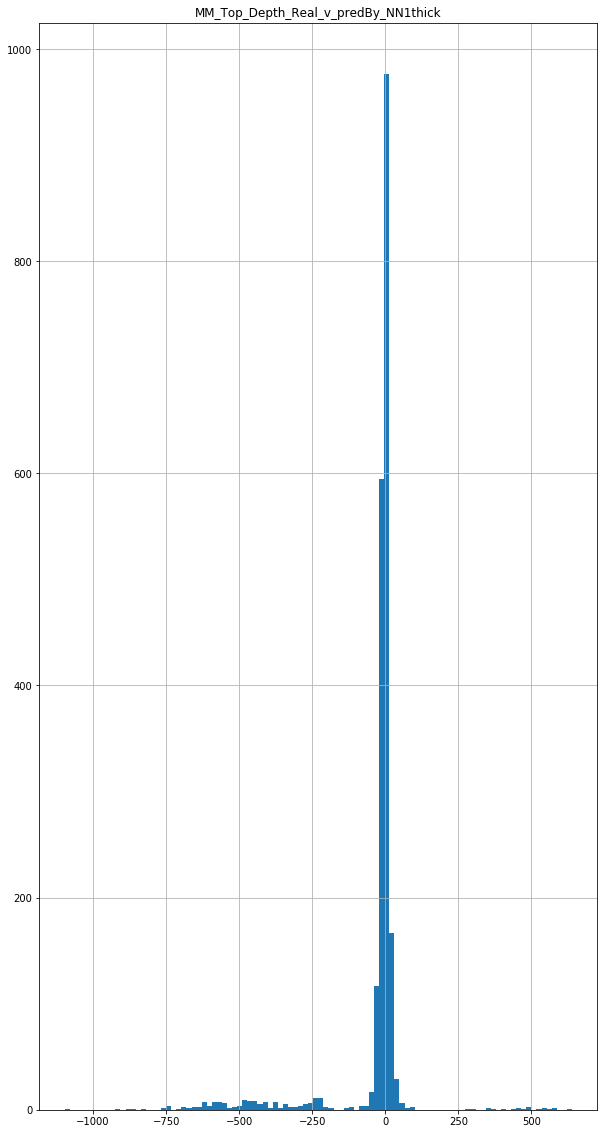

In [60]:
### Positive numbers are where real top is greater than predicted (200 vs. 100)
### Negative numbers are where real top is less than predicted top (0 vs. 500)
### Many negative numbers might be due to :
###    1) zeros & blanks being skipped in nearest neighbors and
###    2) not being skipped in 'real' tops 
doNotSaveThisDF_temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(10,20))

## The really high negative values might be from wells that don't have a base pick ? 0 - thickness in neighboring well where as the high positive numbers might be wells that have a base in neighboring well but not in well being predicting for?

### Let's investigate further by looking at the distribution of the thickness in nieghboring wells

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a138e0080>]], dtype=object)

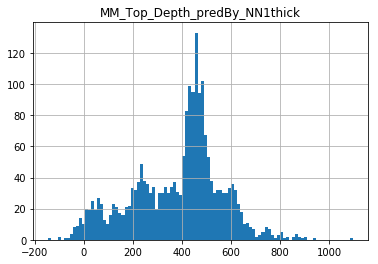

In [61]:
#MM_Top_Depth_Real_v_predBy_NN1thick
# temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100)
temp5.hist(column='MM_Top_Depth_predBy_NN1thick', bins=100)

- Most are around 430 with a big range that has shoulders around 200 and 600 thickness. 
- There are a few with less than zero? Are thosse were there was a base but not a top or the other way?

#### Let's check to see how many McMurray_Top_DEPTH and McMurray_Base_DEPTH are zeros

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a12d1b9b0>]], dtype=object)

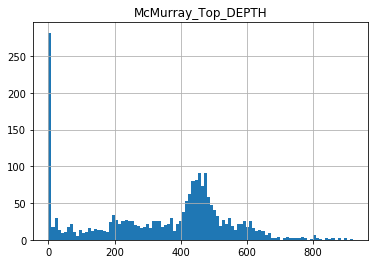

In [62]:
temp5.hist(column='McMurray_Top_DEPTH', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f787198>]], dtype=object)

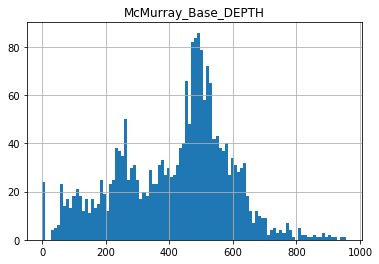

In [63]:
temp5.hist(column='McMurray_Base_DEPTH', bins=100)

### Let's investigate what is causing the problem above and find out where the zeros or missing values are

First, get absolute numbers intead of just a histogram

In [64]:
df_test = temp5.copy()

In [65]:
#### number of rows in each column with null values
df_test.isnull().sum()

SitID                            0
McMurray_Base_HorID              0
McMurray_Top_HorID               0
McMurray_Base_DEPTH              0
McMurray_Top_DEPTH               0
McMurray_Base_Qual               0
McMurray_Top_Qual                0
lat                              0
lng                              0
UWI                              0
Neighbors_Obj                    0
NN1_McMurray_Top_DEPTH          84
NN1_McMurray_Base_DEPTH          0
NN1_thickness                   84
MM_Top_Depth_predBy_NN1thick    84
dtype: int64

In [66]:
#### number of rows in each column with zero values
df_test[df_test.McMurray_Top_DEPTH == 0].count()

SitID                           247
McMurray_Base_HorID             247
McMurray_Top_HorID              247
McMurray_Base_DEPTH             247
McMurray_Top_DEPTH              247
McMurray_Base_Qual              247
McMurray_Top_Qual               247
lat                             247
lng                             247
UWI                             247
Neighbors_Obj                   247
NN1_McMurray_Top_DEPTH          168
NN1_McMurray_Base_DEPTH         247
NN1_thickness                   168
MM_Top_Depth_predBy_NN1thick    168
dtype: int64

#### Looks like both are issue but Top is bigger issue.

In [67]:
df_test[df_test.McMurray_Base_DEPTH == 0].count()

SitID                           24
McMurray_Base_HorID             24
McMurray_Top_HorID              24
McMurray_Base_DEPTH             24
McMurray_Top_DEPTH              24
McMurray_Base_Qual              24
McMurray_Top_Qual               24
lat                             24
lng                             24
UWI                             24
Neighbors_Obj                   24
NN1_McMurray_Top_DEPTH          24
NN1_McMurray_Base_DEPTH         24
NN1_thickness                   24
MM_Top_Depth_predBy_NN1thick    24
dtype: int64

### It appears there are 247 base McMurray picks with zero values and this is causing the problems
### Without a base, we can't add the nearest neighbor McMurray thickness to it and git a starting point to look for the top McMurray pick

### Below we will limit the dataset distribution to  only those wells that do have an interpreted McMurray base pick.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f84a2e8>]], dtype=object)

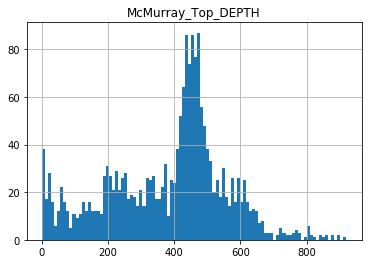

In [68]:
no_zeros_df = df_test[(df_test['McMurray_Base_DEPTH']!=0) & (df_test['McMurray_Top_DEPTH']!=0)]
no_zeros_df.hist(column='McMurray_Top_DEPTH', bins=100)

In [69]:
no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'] =  no_zeros_df['McMurray_Top_DEPTH'] - no_zeros_df['MM_Top_Depth_predBy_NN1thick'] 


/Users/justingosses/anaconda/envs/MannvilleDask/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fac90b8>]], dtype=object)

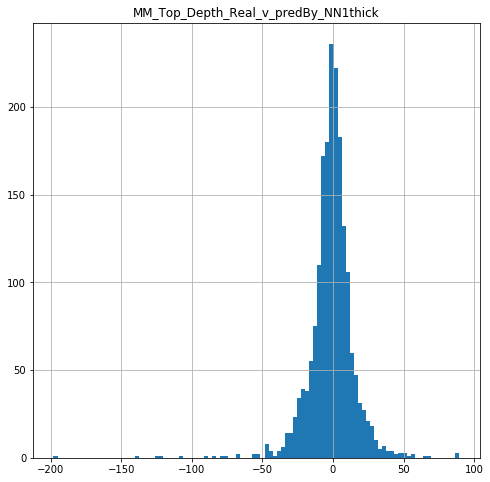

In [70]:
no_zeros_df.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(8,8))

In [71]:
len(no_zeros_df)

1926

### The histogram above seems more reasonable

Let's take out the column that might leak information about a wells top McMurray depth and then save this dataframe.

In [72]:
no_zeros_df_TopDepthVsNNleak = no_zeros_df.drop('MM_Top_Depth_Real_v_predBy_NN1thick', 1)

In [73]:
no_zeros_df_TopDepthVsNNleak

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick
0,102496,14000,13000,561.00,475.00,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]",544.00,630.00,86.00,475.00
1,102497,14000,13000,604.50,515.00,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]",529.00,613.00,84.00,520.50
2,102498,14000,13000,564.00,480.00,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]",529.00,613.00,84.00,480.00
3,102500,14000,13000,636.50,549.00,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]",529.00,613.00,84.00,552.50
4,102501,14000,13000,613.00,529.00,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0501344694696}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0552825613462}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.0771552400618}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0918035212614}]",514.00,603.00,89.00,524.00
5,102503,14000,13000,553.50,488.50,1,2,54.771449,-110.402983,00/11-04-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.0239897104609}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.0585307859165}, {'neighbor': 3, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.064188175679}, {'neighbor': 4, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.087730761401}, {'neighbor': 5, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.0882063766969}, {'neighbor': 6, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.0954310000209}, {'neighbor': 7, 'UWI': 

In [74]:
#### dumping wells dataframe that has no zeros in NN depth to pickle file
pickle.dump(no_zeros_df_TopDepthVsNNleak, open( "wells_df__NB_KDtreePost062018_vA__NoMcTopLeak_v2.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

### Let's look at the results on a map

In [75]:
import os
import folium
print(folium.__version__)
import branca.colormap as cm
import os
import math
env = %env
pd.set_option('display.max_rows', 2000)

0.5.0


In [76]:
linear2 = cm.LinearColormap(
    ['#edf8b1','#7fcdbb','#2c7fb8','#273891'],
    vmin=-100, vmax=75
)

linear2


# linear3 = cm.LinearColormap(
#     ['darkblue','blue','lightblue','lightgreen','green','darkgreen'],
#      vmax=75,vmin=-100,
# )

# linear3

In [77]:
def depth_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 50:
            color = '#3182bd'
        elif depth > 10 and depth < 50:
            color = '#9ecae1'
        elif depth > -10 and depth < 10:
            color = 'green'
        elif depth > -50 and depth < -10:
            color = '#ffeda0'
        elif depth > -150 and depth < -50:
            color = '#feb24c'
        elif depth > -300 and depth < -150:
            color = '#f03b20'
        else:
            color = 'blue'
    return color

In [78]:
def depth_color3(depth,colorMap):
    if(math.isnan(depth)):
        print("!!!!!!!!!!!!!!!!!!!!  ' '  or nan is in depth => ", depth)
        color = '#000000'
    else:
        depth = float(depth)
        print("depth in colormap 3",depth)
        color = colorMap(depth)
        
    print("color = ",color)    
    return color

In [79]:
center2 = [54.840471, -110.269399]
zoom2 = 6
m5 = folium.Map(center2, tiles='Stamen Toner', zoom_start=zoom2)

In [80]:


list_df_for_map = no_zeros_df.values.tolist()

for row in list_df_for_map[0:]:
    print("location = ",row[7:9]," and depth is",row[15:16][0], " and UWI is ",row[9:10][0])
    folium.CircleMarker(
    location=row[7:9],
    radius=2,
    color=depth_color(row[15:16][0]),
    fill=True,
#     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
#     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
    ).add_to(m5)

location =  [54.785906999999995, -110.12931999999999]  and depth is 0.0  and UWI is  00/12-08-067-01W4/0
location =  [54.782284, -110.269446]  and depth is -5.5  and UWI is  00/07-08-067-02W4/0
location =  [54.785892000000004, -110.186851]  and depth is 0.0  and UWI is  00/09-11-067-02W4/0
location =  [54.829624, -110.26942199999999]  and depth is -3.5  and UWI is  00/10-29-067-02W4/0
location =  [54.840470999999994, -110.224832]  and depth is 5.0  and UWI is  00/06-34-067-02W4/0
location =  [54.771449, -110.402983]  and depth is -0.5  and UWI is  00/11-04-067-03W4/0
location =  [54.785901, -110.42213100000001]  and depth is -6.5  and UWI is  00/10-08-067-03W4/0
location =  [54.800532999999994, -110.34576200000001]  and depth is 11.5  and UWI is  00/10-14-067-03W4/0
location =  [54.829632999999994, -110.396621]  and depth is 6.5  and UWI is  00/10-28-067-03W4/0
location =  [54.840441000000006, -110.320301]  and depth is -25.5  and UWI is  00/07-36-067-03W4/0
location =  [54.771451, -11

location =  [54.985939, -110.60614]  and depth is 25.5  and UWI is  00/06-19-069-04W4/0
location =  [55.015046, -110.58071799999999]  and depth is -11.5  and UWI is  00/06-32-069-04W4/0
location =  [54.942413, -110.70156200000001]  and depth is 28.0  and UWI is  00/07-04-069-05W4/0
location =  [54.971501, -110.66318400000002]  and depth is -28.0  and UWI is  00/05-14-069-05W4/0
location =  [54.985963, -110.682404]  and depth is -24.0  and UWI is  00/06-22-069-05W4/0
location =  [55.018671, -110.67612]  and depth is -8.0  and UWI is  00/10-34-069-05W4/0
location =  [54.985963, -110.83499199999999]  and depth is -8.0  and UWI is  00/06-22-069-06W4/0
location =  [55.015052000000004, -110.873301]  and depth is 0.5  and UWI is  00/08-32-069-06W4/0
location =  [55.015042, -110.784125]  and depth is -22.0  and UWI is  00/06-36-069-06W4/0
location =  [54.97150500000001, -111.000449]  and depth is 3.5  and UWI is  00/08-16-069-07W4/0
location =  [55.004192, -111.07006299999999]  and depth is -9

location =  [55.102109999999996, -112.48142]  and depth is 9.829999999999984  and UWI is  00/07-35-070-17W4/0
location =  [55.091302, -112.64015]  and depth is -25.25  and UWI is  00/11-26-070-18W4/0
location =  [55.036766, -112.830976]  and depth is nan  and UWI is  00/16-04-070-19W4/0
 math.isnan(depth) =>  nan
location =  [55.058620999999995, -112.786325]  and depth is -8.439999999999998  and UWI is  00/07-14-070-19W4/0
location =  [55.033087, -113.548895]  and depth is -15.549999999999955  and UWI is  00/10-02-070-24W4/0
location =  [55.076674, -113.58058100000001]  and depth is -11.270000000000095  and UWI is  00/11-22-070-24W4/0
location =  [55.102148, -113.605924]  and depth is -16.010000000000105  and UWI is  00/06-33-070-24W4/0
location =  [55.033085, -113.713816]  and depth is 21.649999999999977  and UWI is  00/12-02-070-25W4/0
location =  [55.073039, -113.73290800000001]  and depth is -21.649999999999977  and UWI is  00/06-22-070-25W4/0
location =  [55.044011, -113.879462000

location =  [55.121506000000004, -114.069445]  and depth is -8.57000000000005  and UWI is  00/11-03-071-01W5/0
location =  [55.132293000000004, -114.15248500000001]  and depth is 1.0  and UWI is  00/05-07-071-01W5/0
location =  [55.17603100000001, -114.04378899999999]  and depth is 4.259999999999991  and UWI is  00/06-26-071-01W5/0
location =  [55.176019999999994, -114.120649]  and depth is -28.24000000000001  and UWI is  00/06-29-071-01W5/0
location =  [55.117839000000004, -114.1592]  and depth is 6.0  and UWI is  00/08-01-071-02W5/0
location =  [55.164947999999995, -114.27434]  and depth is -1.3899999999999864  and UWI is  00/11-20-071-02W5/0
location =  [55.161347, -114.22308600000001]  and depth is 11.590000000000032  and UWI is  00/06-22-071-02W5/0
location =  [55.175971999999994, -114.26801200000001]  and depth is 2.6100000000000136  and UWI is  00/07-29-071-02W5/0
location =  [55.16493199999999, -114.434426]  and depth is -0.20000000000004547  and UWI is  00/12-20-071-03W5/0
loc

location =  [55.280878, -113.477655]  and depth is 1.8000000000000682  and UWI is  00/10-33-072-23W4/0
location =  [55.208211999999996, -113.554585]  and depth is 0.0  and UWI is  00/10-01-072-24W4/0
location =  [55.219079, -113.65712099999999]  and depth is 9.149999999999977  and UWI is  00/07-08-072-24W4/0
location =  [55.262787, -113.682782]  and depth is -9.149999999999977  and UWI is  00/07-30-072-24W4/0
location =  [55.280846, -113.68276399999999]  and depth is 3.1000000000000227  and UWI is  00/10-31-072-24W4/0
location =  [55.204601000000004, -113.836597]  and depth is -1.2300000000001319  and UWI is  00/07-06-072-25W4/0
location =  [55.219086, -113.766079]  and depth is 9.75  and UWI is  00/06-10-072-25W4/0
location =  [55.280855, -113.785322]  and depth is -3.659999999999968  and UWI is  00/10-33-072-25W4/0
location =  [55.233982999999995, -113.93916499999999]  and depth is -25.809999999999945  and UWI is  00/07-16-072-26W4/0
location =  [55.281128, -113.93914699999999]  and 

location =  [55.335482999999996, -112.836621]  and depth is 20.110000000000014  and UWI is  00/07-22-073-19W4/0
location =  [55.368140000000004, -112.91991100000001]  and depth is 14.940000000000055  and UWI is  00/11-31-073-19W4/0
location =  [55.295556999999995, -113.01609599999999]  and depth is 0.9700000000000273  and UWI is  00/10-04-073-20W4/0
location =  [55.310005000000004, -113.048065]  and depth is -31.399999999999977  and UWI is  00/11-08-073-20W4/0
location =  [55.335485999999996, -113.02242700000001]  and depth is 31.399999999999977  and UWI is  00/06-21-073-20W4/0
location =  [55.364576, -113.01609599999999]  and depth is 7.6200000000000045  and UWI is  00/07-33-073-20W4/0
location =  [55.29554399999999, -113.099368]  and depth is 33.370000000000005  and UWI is  00/11-01-073-21W4/0
location =  [55.313625, -113.169978]  and depth is -29.0  and UWI is  00/15-09-073-21W4/0
location =  [55.364565, -113.19561200000001]  and depth is -30.590000000000032  and UWI is  00/07-32-07

location =  [55.382829, -112.29822800000001]  and depth is 3.0500000000000114  and UWI is  00/10-06-074-15W4/0
location =  [55.397279000000005, -112.30455800000001]  and depth is -0.30000000000001137  and UWI is  00/11-07-074-15W4/0
location =  [55.455436999999996, -112.17634199999999]  and depth is -8.039999999999964  and UWI is  00/11-36-074-15W4/0
location =  [55.451857999999994, -112.38148100000001]  and depth is -76.64999999999998  and UWI is  00/06-34-074-16W4/0
location =  [55.411927, -112.554639]  and depth is -4.560000000000002  and UWI is  00/10-16-074-17W4/0
location =  [55.422762, -112.50968700000001]  and depth is 1.82000000000005  and UWI is  00/06-23-074-17W4/0
location =  [55.437388, -112.484048]  and depth is -1.82000000000005  and UWI is  00/06-25-074-17W4/0
location =  [55.37921899999999, -112.689173]  and depth is -29.56000000000006  and UWI is  00/06-03-074-18W4/0
location =  [55.451826000000004, -112.734174]  and depth is -4.8700000000000045  and UWI is  00/07-32-

location =  [55.513501, -113.385764]  and depth is -3.0499999999999545  and UWI is  00/11-20-075-22W4/0
location =  [55.524522999999995, -113.301749]  and depth is -9.750000000000114  and UWI is  00/07-26-075-22W4/0
location =  [55.542595999999996, -113.35349599999999]  and depth is 7.620000000000118  and UWI is  00/10-33-075-22W4/0
location =  [55.462816000000004, -113.502398]  and depth is 9.0  and UWI is  00/01-04-075-23W4/0
location =  [55.477211, -113.51518]  and depth is 12.5  and UWI is  00/03-09-075-23W4/0
location =  [55.499053, -113.56694399999999]  and depth is -6.100000000000023  and UWI is  00/11-18-075-23W4/0
location =  [55.538971, -113.43113400000001]  and depth is 8.540000000000077  and UWI is  00/07-36-075-23W4/0
location =  [55.466395999999996, -113.61231599999999]  and depth is 7.929999999999836  and UWI is  00/07-02-075-24W4/0
location =  [55.4664, -113.670473]  and depth is 22.909999999999968  and UWI is  00/06-04-075-24W4/0
location =  [55.509907999999996, -113.7

location =  [55.615488, -112.55771599999999]  and depth is -7.610000000000014  and UWI is  00/11-27-076-17W4/0
location =  [55.611872, -112.58358799999999]  and depth is -8.240000000000009  and UWI is  00/06-28-076-17W4/0
location =  [55.626327, -112.577202]  and depth is 2.6100000000000136  and UWI is  00/07-33-076-17W4/0
location =  [55.557291000000006, -112.945921]  and depth is -0.18000000000000682  and UWI is  00/11-06-076-19W4/0
location =  [55.557233, -113.09474399999999]  and depth is -139.60000000000002  and UWI is  00/10-06-076-20W4/0
location =  [55.61178100000001, -113.1401]  and depth is -2.5499999999999545  and UWI is  00/08-26-076-21W4/0
location =  [55.62985, -113.14648799999999]  and depth is 5.480000000000018  and UWI is  00/10-35-076-21W4/0
location =  [55.557212, -113.411643]  and depth is 3.0499999999999545  and UWI is  00/11-06-076-22W4/0
location =  [55.597151000000004, -113.30175]  and depth is 7.32000000000005  and UWI is  00/07-23-076-22W4/0
location =  [55.61

location =  [55.644493999999995, -113.17875500000001]  and depth is 2.5499999999999545  and UWI is  00/11-03-077-21W4/0
location =  [55.658931, -113.250003]  and depth is 1.2199999999999136  and UWI is  00/10-07-077-21W4/0
location =  [55.640879000000005, -113.33401]  and depth is 0.2999999999999545  and UWI is  00/06-03-077-22W4/0
location =  [55.68441899999999, -113.359889]  and depth is 25.290000000000077  and UWI is  00/06-21-077-22W4/0
location =  [55.713502000000005, -113.379377]  and depth is -12.31000000000006  and UWI is  00/07-32-077-22W4/0
location =  [55.717119999999994, -113.334011]  and depth is -12.979999999999961  and UWI is  00/11-34-077-22W4/0
location =  [55.640889, -113.560552]  and depth is 0.5299999999999727  and UWI is  00/07-06-077-23W4/0
location =  [55.688042, -113.45702]  and depth is 6.389999999999986  and UWI is  00/10-23-077-23W4/0
location =  [55.702684999999995, -113.489299]  and depth is -36.289999999999964  and UWI is  00/11-27-077-23W4/0
location =  [

location =  [55.80081800000001, -112.738872]  and depth is -21.950000000000045  and UWI is  00/06-33-078-18W4/0
location =  [55.72814399999999, -112.933117]  and depth is 6.5  and UWI is  00/08-06-078-19W4/0
location =  [55.786341, -112.842408]  and depth is 2.5  and UWI is  00/06-26-078-19W4/0
location =  [55.786333, -112.926327]  and depth is -6.839999999999975  and UWI is  00/05-29-078-19W4/0
location =  [55.804365000000004, -113.19824399999999]  and depth is -3.5  and UWI is  00/10-33-078-21W4/0
location =  [55.804356999999996, -113.12700500000001]  and depth is 13.409999999999968  and UWI is  00/11-36-078-21W4/0
location =  [55.728126, -113.40525500000001]  and depth is -12.800000000000011  and UWI is  00/07-06-078-22W4/0
location =  [55.789911, -113.411645]  and depth is 12.800000000000011  and UWI is  00/11-30-078-22W4/0
location =  [55.804347, -113.28226599999999]  and depth is -5.4500000000000455  and UWI is  00/11-36-078-22W4/0
location =  [55.742596999999996, -113.560556]  a

location =  [55.891571, -113.25198799999998]  and depth is 27.769999999999982  and UWI is  00/10-32-079-21W4/0
location =  [55.88795, -113.14757]  and depth is 12.0  and UWI is  00/07-36-079-21W4/0
location =  [55.851631999999995, -113.33673600000002]  and depth is 11.240000000000009  and UWI is  00/14-14-079-22W4/0
location =  [55.858863, -113.38249099999999]  and depth is -11.240000000000009  and UWI is  00/07-21-079-22W4/0
location =  [55.86608199999999, -113.33029199999999]  and depth is -18.5  and UWI is  00/15-23-079-22W4/0
location =  [55.8771, -113.42148600000002]  and depth is 3.5  and UWI is  AA/12-29-079-22W4/0
location =  [55.815338, -113.493346]  and depth is -13.709999999999923  and UWI is  00/06-02-079-23W4/0
location =  [55.840826, -113.47361000000001]  and depth is 13.709999999999923  and UWI is  02/04-13-079-23W4/0
location =  [55.855242000000004, -113.499793]  and depth is -23.22999999999996  and UWI is  00/04-23-079-23W4/0
location =  [55.869877, -113.50656000000001

location =  [55.982412, -113.604133]  and depth is 0.5  and UWI is  00/13-31-080-23W4/0
location =  [55.902565, -113.62386699999999]  and depth is -8.5  and UWI is  00/06-01-080-24W4/0
location =  [55.920648, -113.669615]  and depth is 6.5  and UWI is  00/10-10-080-24W4/0
location =  [55.964362, -113.64995900000001]  and depth is 8.0  and UWI is  00/11-26-080-24W4/0
location =  [55.960751, -113.72825900000001]  and depth is 0.910000000000025  and UWI is  00/06-29-080-24W4/0
location =  [55.906211, -113.90451200000001]  and depth is 0.9599999999999795  and UWI is  00/10-06-080-25W4/0
location =  [55.935295999999994, -113.90451100000001]  and depth is -4.569999999999993  and UWI is  00/10-18-080-25W4/0
location =  [55.9752, -113.78045700000001]  and depth is -13.720000000000027  and UWI is  00/06-36-080-25W4/0
location =  [55.964532999999996, -113.95671599999999]  and depth is -1.1299999999999955  and UWI is  00/10-26-080-26W4/0
location =  [55.907135, -114.141774]  and depth is -4.20000

location =  [56.149838, -110.387133]  and depth is -45.72000000000003  and UWI is  00/06-34-082-03W4/0
location =  [56.095271, -110.59597]  and depth is -47.22000000000003  and UWI is  00/11-08-082-04W4/0
location =  [56.120751, -110.550124]  and depth is 11.0  and UWI is  00/05-22-082-04W4/0
location =  [56.080813, -110.66784399999999]  and depth is -5.6699999999999875  and UWI is  00/10-02-082-05W4/0
location =  [56.12074499999999, -110.72650300000001]  and depth is -18.0  and UWI is  00/06-21-082-05W4/0
location =  [56.12073, -110.64173600000001]  and depth is 48.5  and UWI is  00/07-24-082-05W4/0
location =  [56.10991800000001, -110.824475]  and depth is 19.810000000000002  and UWI is  00/10-14-082-06W4/0
location =  [56.124385, -110.902795]  and depth is 13.690000000000026  and UWI is  00/10-20-082-06W4/0
location =  [56.120740000000005, -110.79836399999999]  and depth is -2.430000000000007  and UWI is  00/07-24-082-06W4/0
location =  [56.153476, -110.876673]  and depth is 11.5699

location =  [56.182651, -111.87223300000001]  and depth is 1.830000000000041  and UWI is  AA/12-08-083-12W4/0
location =  [56.18265699999999, -111.79323500000001]  and depth is 7.289999999999964  and UWI is  AA/12-11-083-12W4/0
location =  [56.226367, -111.77381100000001]  and depth is -1.8199999999999932  and UWI is  AA/09-26-083-12W4/0
location =  [56.226374, -111.85280900000001]  and depth is -0.6100000000000136  and UWI is  AA/09-29-083-12W4/0
location =  [56.193673, -111.997491]  and depth is 8.230000000000018  and UWI is  00/06-16-083-13W4/0
location =  [56.208117, -111.93831399999999]  and depth is -1.830000000000041  and UWI is  00/07-23-083-13W4/0
location =  [56.211726, -112.18183]  and depth is -19.100000000000023  and UWI is  00/11-20-083-14W4/0
location =  [56.226363, -112.28718]  and depth is -0.910000000000025  and UWI is  00/11-27-083-15W4/0
location =  [56.240809999999996, -112.33335600000001]  and depth is -4.589999999999975  and UWI is  00/10-32-083-15W4/0
location =

location =  [56.415333999999994, -110.970492]  and depth is 25.5  and UWI is  AA/11-36-085-07W4/0
location =  [56.349941, -111.233846]  and depth is 1.8000000000000114  and UWI is  AA/03-08-085-08W4/0
location =  [56.382654, -111.194505]  and depth is 4.880000000000052  and UWI is  AA/08-21-085-08W4/0
location =  [56.382639000000005, -111.128474]  and depth is -2.7399999999999807  and UWI is  AA/06-24-085-08W4/0
location =  [56.357165, -111.31284099999999]  and depth is -5.660000000000025  and UWI is  AA/11-11-085-09W4/0
location =  [56.397262, -111.292953]  and depth is 2.160000000000025  and UWI is  AA/05-25-085-09W4/0
location =  [56.397263, -111.299858]  and depth is 5.660000000000025  and UWI is  AA/08-26-085-09W4/0
location =  [56.357175, -111.47724099999999]  and depth is -10.029999999999973  and UWI is  AA/12-11-085-10W4/0
location =  [56.342704000000005, -111.60248100000001]  and depth is -1.5  and UWI is  00/11-01-085-11W4/0
location =  [56.342696999999994, -111.734145]  and 

location =  [56.62250699999999, -111.49750900000001]  and depth is 15.240000000000009  and UWI is  AA/16-10-088-10W4/0
location =  [56.655381999999996, -111.510579]  and depth is 14.340000000000018  and UWI is  AA/03-27-088-10W4/0
location =  [56.669821, -111.470846]  and depth is -15.240000000000009  and UWI is  AA/01-35-088-10W4/0
location =  [56.629898, -111.789818]  and depth is -4.260000000000019  and UWI is  AA/08-14-088-12W4/0
location =  [56.651585, -111.836091]  and depth is 0.6099999999999852  and UWI is  AA/13-22-088-12W4/0
location =  [56.677001000000004, -112.068776]  and depth is 1.8900000000000148  and UWI is  AA/11-31-088-13W4/0
location =  [56.662552000000005, -112.1951]  and depth is -1.7199999999999989  and UWI is  AA/10-29-088-14W4/0
location =  [56.680631999999996, -112.161971]  and depth is -3.8499999999999943  and UWI is  AA/16-33-088-14W4/0
location =  [56.618854000000006, -112.35453500000001]  and depth is 2.5  and UWI is  AA/10-08-088-15W4/0
location =  [56.61

location =  [56.822399, -113.105585]  and depth is 1.0  and UWI is  00/11-22-090-20W4/0
location =  [56.855138000000004, -113.10558400000001]  and depth is -1.0  and UWI is  00/14-34-090-20W4/0
location =  [56.844243999999996, -113.058897]  and depth is 4.5  and UWI is  00/04-36-090-20W4/0
location =  [56.85909100000001, -111.122431]  and depth is -4.5  and UWI is  AA/03-06-091-07W4/0
location =  [56.902674, -111.10213799999998]  and depth is -9.140000000000015  and UWI is  AA/04-20-091-07W4/0
location =  [56.931765000000006, -111.048475]  and depth is 12.670000000000016  and UWI is  AA/04-34-091-07W4/0
location =  [56.859097, -111.155796]  and depth is 11.5  and UWI is  AA/04-01-091-08W4/0
location =  [56.928155000000004, -111.289875]  and depth is 14.019999999999996  and UWI is  AA/13-30-091-08W4/0
location =  [56.869980000000005, -111.323678]  and depth is 4.260000000000005  and UWI is  AA/16-02-091-09W4/0
location =  [56.899074, -111.39718400000001]  and depth is -25.60000000000001

location =  [57.135376, -111.504535]  and depth is 1.5  and UWI is  AA/04-11-094-10W4/0
location =  [57.164464, -111.504529]  and depth is -25.0  and UWI is  AA/04-23-094-10W4/0
location =  [57.193536, -111.52472]  and depth is 49.59  and UWI is  AA/03-34-094-10W4/0
location =  [57.128114000000004, -111.772749]  and depth is 10.0  and UWI is  AB/12-06-094-11W4/0
location =  [57.13896, -111.652289]  and depth is 4.880000000000001  and UWI is  AB/07-11-094-11W4/0
location =  [57.153601, -111.705867]  and depth is 8.23  and UWI is  AA/07-16-094-11W4/0
location =  [57.186298, -111.752866]  and depth is -22.859999999999992  and UWI is  AA/09-30-094-11W4/0
location =  [57.124481, -111.79950600000001]  and depth is -7.5  and UWI is  AA/05-01-094-12W4/0
location =  [57.128092, -111.80655]  and depth is 3.5  and UWI is  AA/09-02-094-12W4/0
location =  [57.135312, -111.91391200000001]  and depth is -1.519999999999989  and UWI is  AA/01-07-094-12W4/0
location =  [57.179072999999995, -111.80655900

location =  [57.34980899999999, -112.47458200000001]  and depth is 14.5  and UWI is  00/16-23-096-16W4/0
location =  [57.353640000000006, -112.460875]  and depth is 3.67999999999995  and UWI is  AA/03-25-096-16W4/0
location =  [57.353657, -112.54211699999999]  and depth is -15.5  and UWI is  AA/03-28-096-16W4/0
location =  [57.357213, -112.582908]  and depth is 3.5  and UWI is  AA/08-30-096-16W4/0
location =  [57.419037, -110.883548]  and depth is -5.700000000000003  and UWI is  AA/10-15-097-06W4/0
location =  [57.448117, -110.883548]  and depth is -21.5  and UWI is  AA/10-27-097-06W4/0
location =  [57.448113, -110.937696]  and depth is -55.5  and UWI is  AA/10-29-097-06W4/0
location =  [57.46256700000001, -110.910623]  and depth is 36.5  and UWI is  AA/10-33-097-06W4/0
location =  [57.382729000000005, -111.07308400000001]  and depth is 39.77000000000001  and UWI is  AA/02-04-097-07W4/0
location =  [57.419019999999996, -111.127245]  and depth is 14.5  and UWI is  AA/10-18-097-07W4/0
lo

location =  [57.771529, -112.013236]  and depth is 13.830000000000041  and UWI is  AA/15-14-101-13W4/0
location =  [57.771530000000006, -112.088554]  and depth is -7.250000000000057  and UWI is  AA/16-17-101-13W4/0
location =  [57.796999, -112.04735]  and depth is 2.250000000000057  and UWI is  AA/11-27-101-13W4/0
location =  [57.796978, -112.129423]  and depth is 4.2999999999999545  and UWI is  AA/11-30-101-13W4/0
location =  [57.753273, -112.266195]  and depth is -2.0  and UWI is  AA/11-08-101-14W4/0
location =  [57.77151800000001, -112.18413500000001]  and depth is 0.30000000000001137  and UWI is  AA/14-14-101-14W4/0
location =  [57.793366000000006, -112.266201]  and depth is 23.299999999999955  and UWI is  AA/06-29-101-14W4/0
location =  [57.80781700000001, -112.18413899999999]  and depth is -4.2999999999999545  and UWI is  AA/06-35-101-14W4/0


In [81]:
m5

### In general it seems the variance is relatively evenly distributed. 
A lot of the map has green, which means the neighboring wells thickness + base results in a top prediction that is within plus or minues 10 feet. Where the difference is outside that range, it seems it isn't that much farther off most of the time. There might be some areas in NE and eastern margin where variance is larger than in central area.

In [82]:
m5.save(os.path.join('.', 'MM_Top_Depth_Real_v_predBy_NN1thick_v2.html'))

#### might try this d3.js block of leaflet.js for ideas on how to draw polygons over the map and then use those polygons as features.

https://bl.ocks.org/danswick/d30c44b081be31aea483

### Future work

In [83]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    
    
    return uwi_array, distance_array
    

In [84]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return uwi_nearest, uwi_array, nearest_TopM_depth, avg_TopM_depth, nearest_BaseM_depth, avg_BaseM_depth
    

In [85]:
#### 2. Return an array of pick depths at N neighbor wells within a certain maximum distance.
#### takes in array or pandas df? returns dataframe?
def arrayOfPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return array_of_depths
    

In [86]:
#### 3. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def avgDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return avg_of_depthsAbvBelow

In [87]:
#### 4. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def arrayDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return array_of_depthsAbvBelow